# Setup
- Imports
- Library installing
- Ollama setup
- Models installing
- Definition of classes used in our work, namely: RAC, RAG, LLM-Augmented-KNN.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer
from typing import Literal
from warnings import warn
import string
import re
import random
from random import choice
import json

In [2]:
! pip install faiss-gpu-cu12
! pip install -q datasets
! pip install -q langchain-ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import faiss
import langchain_ollama
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import ChatPromptTemplate
from datasets import load_dataset

In [4]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
project_path= '/content/drive/MyDrive/P10- RAG-GAS/'
os.chdir(project_path)

Mounted at /content/drive


In [5]:
!sudo apt -q update > /dev/null 2>&1
!sudo apt install -y -q pciutils > /dev/null 2>&1
!curl -q -fsSL https://ollama.com/install.sh | sh > /dev/null 2>&1

In [27]:
# Run this after keyboard interupts to re-start model generation.
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()

In [8]:
!ollama pull mistral >> /dev/null 2>&1

In [ ]:
! ollama pull llama3.2 >> /dev/null 2>&1

In [ ]:
! ollama pull llama2:13b >> /dev/null 2>&1

In [9]:
from sklearn.metrics import precision_recall_fscore_support

def _compute_metrics(y_true, y_pred):

    # Ottieni gli indici dove y_pred è un valore booleano
    _to_evaluate = [i for i, val in enumerate(y_pred) if isinstance(val, bool)]

    # Filtra y_true e y_pred utilizzando gli indici
    y_true_filtered = [bool(y_true[i]) for i in _to_evaluate]
    y_pred_filtered = [(y_pred[i]) for i in _to_evaluate]

    # Calculate precision, recall, and F1 score for each class
    p, r, f, _ = precision_recall_fscore_support(y_true_filtered, y_pred_filtered, average=None, zero_division=0)

    # Handle missing values if there are no positive or negative labels in the data
    p_pos = p[1] if len(p) > 1 else 0  # Positive class precision
    r_pos = r[1] if len(r) > 1 else 0  # Positive class recall
    f_pos = f[1] if len(f) > 1 else 0  # Positive class F1 score
    p_neg = p[0] if len(p) > 0 else 0  # Negative class precision
    r_neg = r[0] if len(r) > 0 else 0  # Negative class recall
    f_neg = f[0] if len(f) > 0 else 0  # Negative class F1 score

    # Calculate the averages
    avg_p = (p_pos + p_neg) / 2
    avg_r = (r_pos + r_neg) / 2
    avg_f1 = (f_pos + f_neg) / 2

    return {
        'Avg(P)': avg_p,
        'Avg(R)': avg_r,
        'Avg(F1)': avg_f1,
        'P(+)': p_pos,
        'R(+)': r_pos,
        'F1(+)': f_pos,
        'P(-)': p_neg,
        'R(-)': r_neg,
        'F1(-)': f_neg,
    }

In [10]:
def compute_avgf1(y_true, y_pred):
  return _compute_metrics(y_true, y_pred)['Avg(F1)']

## Retrieval-System
Run here to define the Retrieval System.
The retrieval system, given an embedding model and a DB, will compute DB's embeddings, storing them with faiss for fast retrieval.

FAISS indexing is used for 4 types of metric: DOT PRODUCT (IP), COSINE SIMILARITY, L2 and L2 with scaled vectors.

Although we miss of data in languages rather than English, it is also possible to specify the language to be used. This works provided that the DB has a column storing the corpus in that language.

In [11]:
class RetrievalSystem:

  def __init__(
      self,
      db : pd.DataFrame,
      embedding_model_name : str,
      lang = 'eng',
  ):
    # DB
    self.db = db
    self.db_positive = db[db['Successful']]
    self.db_negative = db[~db['Successful']]

    # Instantiate embedding model
    print(f"Instantiating embedding model: {embedding_model_name}")
    self.embedding_model_name = embedding_model_name
    self.embedding_model = SentenceTransformer(self.embedding_model_name)
    self._summary_name = "Summary" if lang == 'eng' else lang + "_Summary"

    self._set_up_semantic_search()

    print("System created.")

  def _set_up_semantic_search(self):
    # Set-up for semantic search
    self.pos_embeddings= {}
    self.neg_embeddings= {}
    self.embeddings= {}

    self.pos_index= {}
    self.neg_index= {}
    self.index= {}

    ## Generate embeddings
    print("Generating embeddings")
    ### Not Scaled
    self.pos_embeddings['not_scaled'] = self.embedding_model.encode(self.db_positive[self._summary_name].tolist())
    self.neg_embeddings['not_scaled'] = self.embedding_model.encode(self.db_negative[self._summary_name].tolist())
    self.embeddings['not_scaled'] = self.embedding_model.encode(self.db[self._summary_name].tolist())
    ### Scaled
    print("Scaling embeddigs...")
    self.pos_embeddings['scaled'] = self.pos_embeddings['not_scaled'].copy()
    self.neg_embeddings['scaled'] = self.neg_embeddings['not_scaled'].copy()
    self.embeddings['scaled'] = self.embeddings['not_scaled'].copy()
    faiss.normalize_L2(self.pos_embeddings['scaled'])
    faiss.normalize_L2(self.neg_embeddings['scaled'])
    faiss.normalize_L2(self.embeddings['scaled'])

    ## Instantiate FAISS indexes
    ### For IP
    print("Creating indexing for IP")
    self.pos_index['IP'] = faiss.IndexFlatIP(self.pos_embeddings['not_scaled'].shape[1])
    self.pos_index['IP'].add(self.pos_embeddings['not_scaled'])
    self.neg_index['IP'] = faiss.IndexFlatIP(self.neg_embeddings['not_scaled'].shape[1])
    self.neg_index['IP'].add(self.neg_embeddings['not_scaled'])
    self.index['IP'] = faiss.IndexFlatIP(self.embeddings['not_scaled'].shape[1])
    self.index['IP'].add(self.embeddings['not_scaled'])


    ### For Cosine similarity
    print("Creating indexing for COS")
    self.pos_index['COS'] = faiss.IndexFlatIP(self.pos_embeddings['scaled'].shape[1])
    self.pos_index['COS'].add(self.pos_embeddings['scaled'])
    self.neg_index['COS'] = faiss.IndexFlatIP(self.neg_embeddings['scaled'].shape[1])
    self.neg_index['COS'].add(self.neg_embeddings['scaled'])
    self.index['COS'] = faiss.IndexFlatIP(self.embeddings['scaled'].shape[1])
    self.index['COS'].add(self.embeddings['scaled'])

    ### For L2-not_scaled
    print("Creating indexing for L2-NOT-SCALED")
    self.pos_index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.pos_embeddings['not_scaled'].shape[1])
    self.pos_index['L2-NOT-SCALED'].add(self.pos_embeddings['not_scaled'])
    self.neg_index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.neg_embeddings['not_scaled'].shape[1])
    self.neg_index['L2-NOT-SCALED'].add(self.neg_embeddings['not_scaled'])
    self.index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.embeddings['not_scaled'].shape[1])
    self.index['L2-NOT-SCALED'].add(self.embeddings['not_scaled'])

    ### For L2-scaled
    print("Creating indexing for L2-SCALED")
    self.pos_index['L2-SCALED'] = faiss.IndexFlatL2(self.pos_embeddings['scaled'].shape[1])
    self.pos_index['L2-SCALED'].add(self.pos_embeddings['scaled'])
    self.neg_index['L2-SCALED'] = faiss.IndexFlatL2(self.neg_embeddings['scaled'].shape[1])
    self.neg_index['L2-SCALED'].add(self.neg_embeddings['scaled'])
    self.index['L2-SCALED'] = faiss.IndexFlatL2(self.embeddings['scaled'].shape[1])
    self.index['L2-SCALED'].add(self.embeddings['scaled'])


  @staticmethod
  def _filter_and_limit(similarity, indices, upper_bound, lower_bound):

      if upper_bound is not None:
          mask = similarity <= upper_bound
          similarity = similarity[mask]
          indices = indices[mask]

      if lower_bound is not None:
          mask = similarity >= lower_bound
          similarity = similarity[mask]
          indices = indices[mask]

      return similarity, indices


  def retrieve(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound : float = None,
        lower_bound : float = None,
        metric : str = 'IP'
  ) -> pd.DataFrame:
      """
      Retrieve examples from memory based on similarity to the query.
      Args:
          query (str): The query summary to retrieve examples for.
          top_k (int): The number of examples to retrieve.
          split (bool): Whether to use separate positive and negative indices.
          upper_bound (float): maximum similarity score.
          lower_bound (float): minimum similarity score

      Returns:
          pd.DataFrame: A DataFrame of the retrieved examples with a 'distance' column.
      """
      query_embedding = self.embedding_model.encode([query])
      if metric in ['COS','L2-SCALED']:
        faiss.normalize_L2(query_embedding)

      if not split:
          metric_score, indices = self.index[metric].search(query_embedding, top_k)
          metric_score, indices = RetrievalSystem._filter_and_limit(metric_score[0], indices[0], upper_bound=upper_bound,lower_bound=lower_bound)
          retrieved_df = self.db.iloc[indices].copy()
          retrieved_df[metric] = metric_score

      else:
          metric_score_pos, indices_pos = self.pos_index[metric].search(query_embedding, top_k)
          metric_score_neg, indices_neg = self.neg_index[metric].search(query_embedding, top_k)

          metric_score_pos, indices_pos = RetrievalSystem._filter_and_limit(metric_score_pos[0], indices_pos[0], upper_bound=upper_bound,lower_bound=lower_bound)
          metric_score_neg, indices_neg = RetrievalSystem._filter_and_limit(metric_score_neg[0], indices_neg[0], upper_bound=upper_bound,lower_bound=lower_bound)

          pos_retrieved = self.db_positive.iloc[indices_pos].copy()
          pos_retrieved[metric] = metric_score_pos

          neg_retrieved = self.db_negative.iloc[indices_neg].copy()
          neg_retrieved[metric] = metric_score_neg

          retrieved_df = pd.concat([pos_retrieved, neg_retrieved])

      return retrieved_df.sort_values(by=metric, ascending = True if 'L2' in metric else False)

  def __call__(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound : float = None,
        lower_bound : float = None,
        metric : str = 'IP'
  ) -> pd.DataFrame:
      return self.retrieve(query,top_k,split,upper_bound,lower_bound,metric)

## Retrieval Classification for Model Selection and Baseline Setting

Given a `Retrieval System`, this class is used to label points according to one out of four policies : `knn`,`weighted-knn`,`rarity` and `sampling`.

- `knn`: labels (+) or (-) according to a majority vote scheme
- `weighted-knn`: same as `knn`, but votes are scaled by distance (i.e. the farther the less important, the closer the more important).
- `rarity`: this modality has the role of demostrating that our DB is to crowded of (-) examples, reducing the potentiality of the model. This modality scales both (+) and (-)  according to label frequency in DB. It is equivalent to label a query q positive whenever a positive element is retrieved among the k-nearest-neighbors as far as k < $\frac{1}{|DB|}$, (k < 94 while the whole DB is used)
- `Sampling`: computes a pdf through softmax using as weights the inverse of the distance squared. A sample is sampled from the neighborhood according such pdf, and its label is then assigned to the query q.

In [12]:
class RAC:
    _EPS=1e-12
    policies = ['knn','weighted-knn','sampling','rarity']

    def __init__(
        self,
        retrieval_system : RetrievalSystem,
    ):
      self.retrieval_system = retrieval_system
      self._pos_rarity = self.retrieval_system.db_positive.shape[0] / self.retrieval_system.db.shape[0]
      self._neg_rarity = self.retrieval_system.db_negative.shape[0] / self.retrieval_system.db.shape[0]
      self.rarity_map = {True : 1 / self._pos_rarity, False : 1/ self._neg_rarity}

    @staticmethod
    def _knn(neighborhood : pd.DataFrame):
      return neighborhood['Successful'].mode()[0]

    @staticmethod
    def _weighted_knn(neighborhood : pd.DataFrame, metric : str, rarity_rescale : bool, rarity_map : dict = None):
      # Weight
      if metric in ['IP', 'COS']:
        w = neighborhood[metric]
      elif 'L2' in metric :
        w = 1 / (neighborhood[metric] + RAC._EPS)
      else :
        raise ValueError(f"Metric {metric} not defined")

      # Rarity Rescaling
      if rarity_rescale:
        w = neighborhood[metric] * neighborhood['Successful'].map(rarity_map)

      # Votes
      _pos_votes = sum(w * neighborhood['Successful'])
      _neg_votes = sum(w * ~neighborhood['Successful'])

      if _pos_votes > _neg_votes:
        label = True
      elif _pos_votes < _neg_votes:
        label = False
      else:
        # Random
        label = choice([_pos_votes,_neg_votes])

      return label

    @staticmethod
    def _sampling(neighborhood : pd.DataFrame, metric : str):

      # Compute Weights
      if metric == 'IP':
        # Avoids exploding
        neighborhood[metric]= neighborhood[metric] / (neighborhood[metric].sum() + RAC._EPS)

      if 'L2' in metric:
        # Distance-based behaves conversely
        neighborhood[metric] = -neighborhood[metric]

      # Individual contribute to the prob. distribution
      _input_vectors = np.exp(neighborhood[metric])

      # Softmax
      neighborhood['p'] = _input_vectors / (np.sum(_input_vectors) + RAC._EPS)

      # Sample
      labeler = neighborhood.sample(n=1,weights = 'p').iloc[-1]

      # Label
      label = labeler['Successful']

      return label

    def classify(
        self,
        query : str,
        policy : str,
        metric : str = 'IP',
        *args,
        **kwargs,
    ) -> bool:

      if policy not in RAC.policies:
        raise ValueError(f"{policy} not available. Please choose among: {RAC.policies}")

      # Retreive
      neighborhood = self.retrieval_system(query,split=False, metric = metric, **kwargs)

      if policy == 'knn':
        # Majority Vote
        label = RAC._knn(neighborhood)

      if policy == "weighted-knn":
        label = RAC._weighted_knn(neighborhood,metric,rarity_rescale=False)

      if policy == 'rarity':
        label = RAC._weighted_knn(neighborhood,metric,rarity_rescale=True,rarity_map = self.rarity_map)

      if policy == 'sampling':
        label = RAC._sampling(neighborhood,metric)

      return label

    def __call__(
        self,
        query : str,
        policy : str,
        metric : str = 'IP',
        *args,
        **kwargs,
    ) -> bool:
      return self.classify(query,policy,metric,*args,**kwargs)


## RAG

In [29]:
class RAG:

  def __init__(self,retrieval_system : RetrievalSystem,model_name : str,**kwargs):
    self.retrieval_system = retrieval_system
    self.model_name = model_name
    self.model = OllamaLLM(model=model_name,**kwargs)

  @staticmethod
  def _normalize(resp : str):
    _r = resp.strip().strip("\n").strip('.').upper()
    if "YES" in _r:
      return True
    if ( "NO" in _r) or ("NOT" in _r):
      return False
    else:
      # Split in words
      answer = _r.split()[0]
      answer = answer.strip().translate(str.maketrans('', '', string.punctuation)).upper()
      if answer == "YES":
        return True
      if (answer == "NO") or (answer == "NOT"):
        return False

    warn(f"The answer {resp} does not match neither YES nor NO.")
    return resp

  @staticmethod
  def print_prompt(template,description,examples,k = -1 ,true_count = -1 ,false_count= -1):
    print(template.format(
        description=description,
        examples=examples,
        k=k,
        true_count=true_count,
        false_count=false_count
    ))

  def generate(
      self,
      query : str,
      prompt_template : str,
      example_template: str,
      print_prompt : bool = False,
      **kwargs
  ) -> str:

    # Retrieve
    neighborhood = self.retrieval_system(query,**kwargs)

    # Format examples
    examples = "\n".join(
        example_template.format(
            i=index + 1,
            description=r[self.retrieval_system._summary_name],
            label="YES" if r['Successful'] else "NO")
        for index, (_,r) in enumerate(neighborhood.iterrows()))

    # Create Prompt and chain
    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = prompt | self.model

    if print_prompt:
      RAG.print_prompt(prompt_template,query,examples)

    # Ask the model
    invoke_dict = {
        'examples':examples,
        'description':query,
        'k': kwargs.get('top_k'),
        'true_count': f"{neighborhood['Successful'].sum()}",
        'false_count' :f"{(~neighborhood['Successful']).sum()}"
      }

    # Ask the model
    return chain.invoke(invoke_dict)

  def __call__(
        self,
        query : str,
        prompt_template : str,
        example_template: str,
        print_prompt : bool = False,
        **kwargs
    ) -> str:
      return RAG._normalize(
          self.generate(query,prompt_template,example_template,print_prompt,**kwargs)
      )

# DATA: Loading, Analysis, Exploration.

In [ ]:
# Read Data
data = pd.read_csv('data_eng.csv').drop(['Unnamed: 0','Repair_Code','Performed_By','Repair_Image','Damage_Image','Kit_Size_str','Pipe_Size','Kit_Compliance'],axis = 1)

## Exploratory Data Analysis (EDA)

Data are higly unbalanced: 99 (-) examples for 1 (+).

By exploring tabular data, one can notice some heuristics: there are some conditions for which a pipe CANNOT be repaired (through patches).


In [ ]:
data.shape

(11904, 15)

In [ ]:
data_positive = data[data['Successful']]
data_negative = data[~data['Successful']]

In [ ]:
data_positive.shape

(126, 15)

In [ ]:
data_negative.shape

(11778, 15)

In [ ]:
import pandas as pd

# Example: Assuming `data` is your dataframe
result = []
for col in data.drop(['ID','Summary','Summary_1'],axis=1).columns:
    if col == 'Successful':  # Skip the 'Successful' column itself
        continue

    # Unique values in the entire column
    all_values = set(data[col].unique())

    # Unique values in each group
    positive_values = set(data[data['Successful'] == True][col].unique())
    negative_values = set(data[data['Successful'] == False][col].unique())

    # Determine the excluded elements
    excluded_positive = all_values - positive_values
    excluded_negative = all_values - negative_values

    # Append the results
    result.append([
        col,
        len(all_values),
        len(positive_values),
        len(negative_values),
        list(excluded_positive) if len(excluded_positive) > 0 else "None",  # Excluded from the positive group
        list(excluded_negative)   # Excluded from the negative group
    ])

# Create the final table
result_df = pd.DataFrame(
    result,
    columns=['Feature', '#UNIQUE VALUES', 'Patchable (+)', 'Not Patchable (-)', 'Values Excluded in (+)', 'Excluded in -']
)
result_df.drop('Excluded in -',axis = 1)
features_with_excluded_values = result_df[result_df['Values Excluded in (+)'] != 'None']
values_excluded = features_with_excluded_values['Values Excluded in (+)'].tolist()

In [ ]:
result_df

,Feature,#UNIQUE VALUES,Patchable (+),Not Patchable (-),Values Excluded in (+),Excluded in -
0,Kit_Size_num,5,5,5,None,[]
1,Pipe_In_Bad_Conditions,2,2,2,None,[]
2,Pipe_Material,6,6,6,None,[]
3,Damage_Type,11,9,11,"[Visible deformation in axial direction, Shear...",[]
4,Pipe_Exposure,3,3,3,None,[]
5,Severe_Corrosion,2,1,2,[True],[]
6,Pipe_Covered,2,1,2,[True],[]
7,Branch_Near_Fault,2,1,2,[True],[]
8,High_Pressure,2,1,2,[True],[]
9,Damaged_Valve,2,1,2,[True],[]


In [ ]:
features_with_excluded_values

,Feature,#UNIQUE VALUES,Patchable (+),Not Patchable (-),Values Excluded in (+),Excluded in -
3,Damage_Type,11,9,11,"[Visible deformation in axial direction, Shear...",[]
5,Severe_Corrosion,2,1,2,[True],[]
6,Pipe_Covered,2,1,2,[True],[]
7,Branch_Near_Fault,2,1,2,[True],[]
8,High_Pressure,2,1,2,[True],[]
9,Damaged_Valve,2,1,2,[True],[]
10,Ribs,2,1,2,[True],[]


In [ ]:
data[data['Successful']].shape[0] / data.shape[0]

0.010584677419354838

In [ ]:
data[~data['Successful']].shape[0] / data.shape[0]

0.9894153225806451

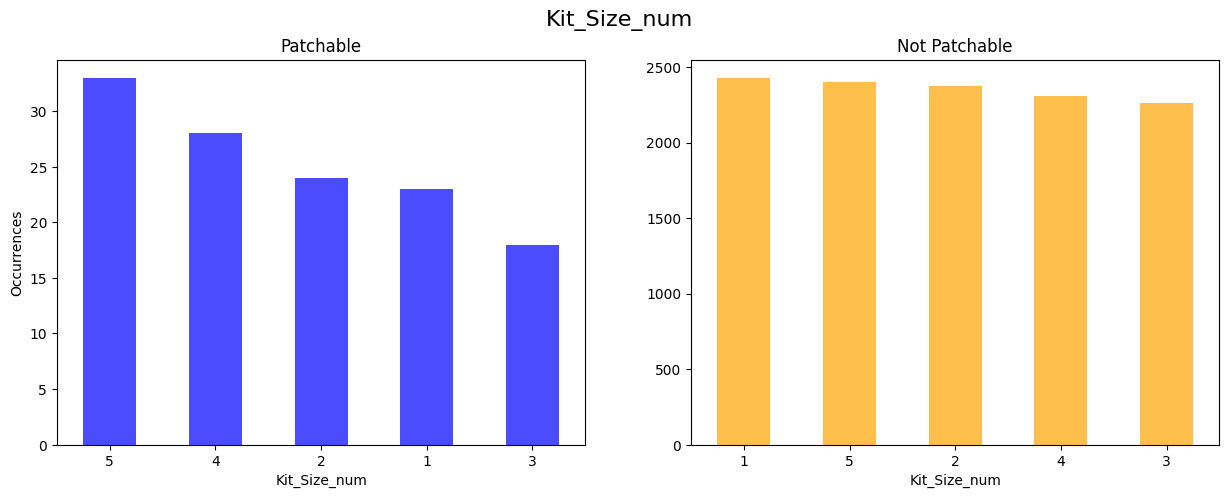

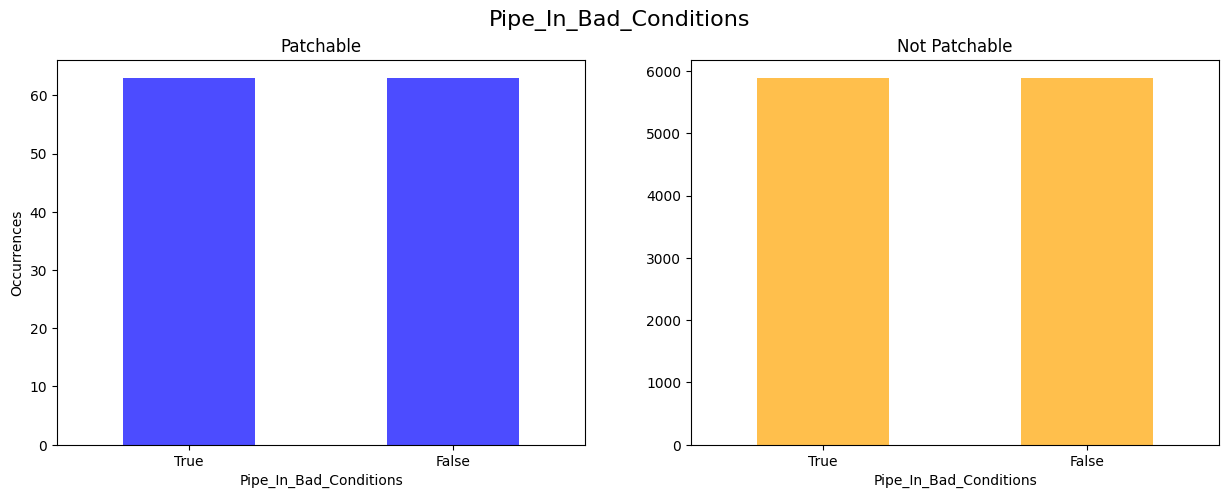

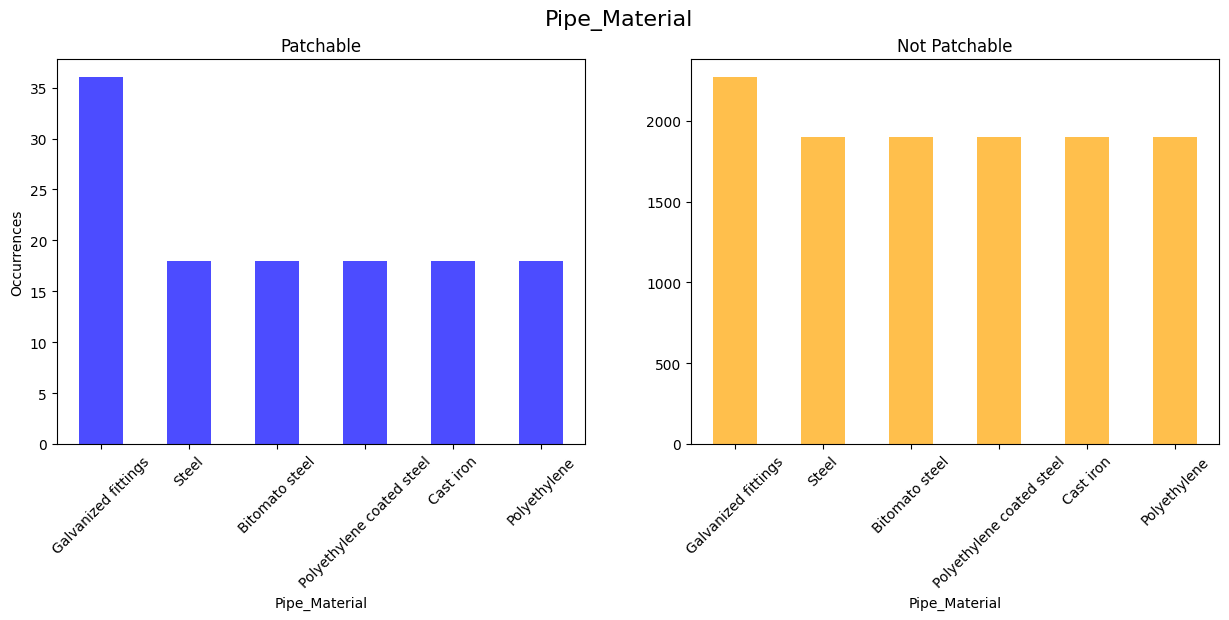

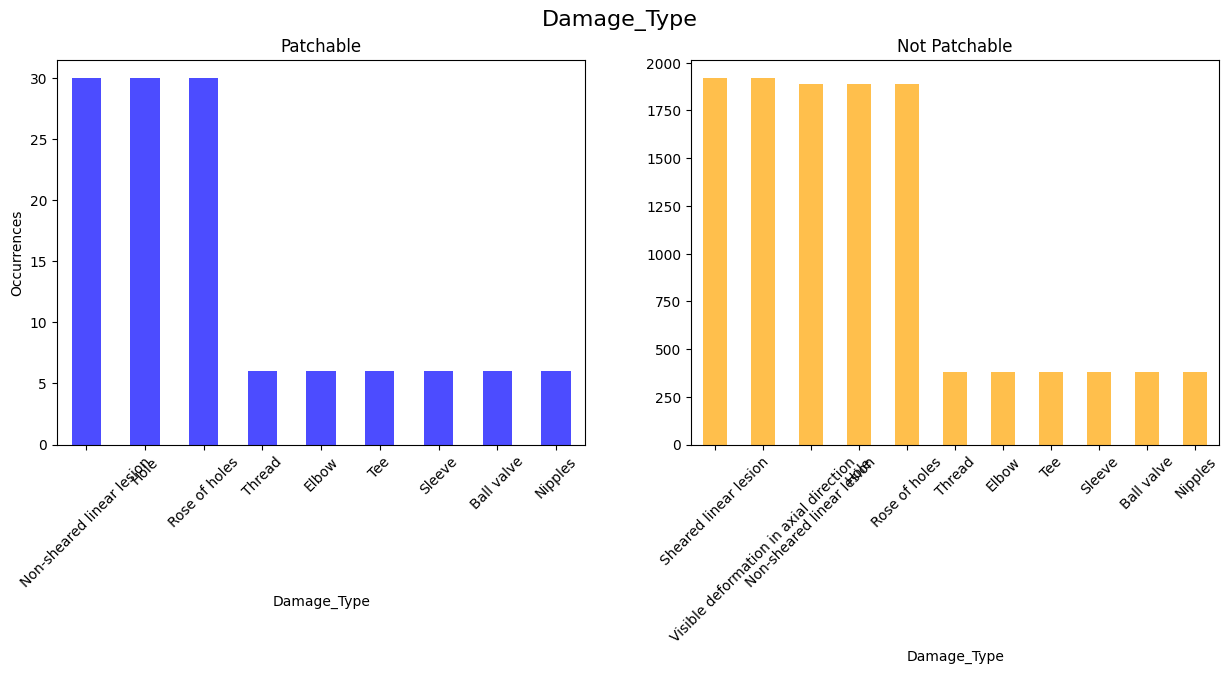

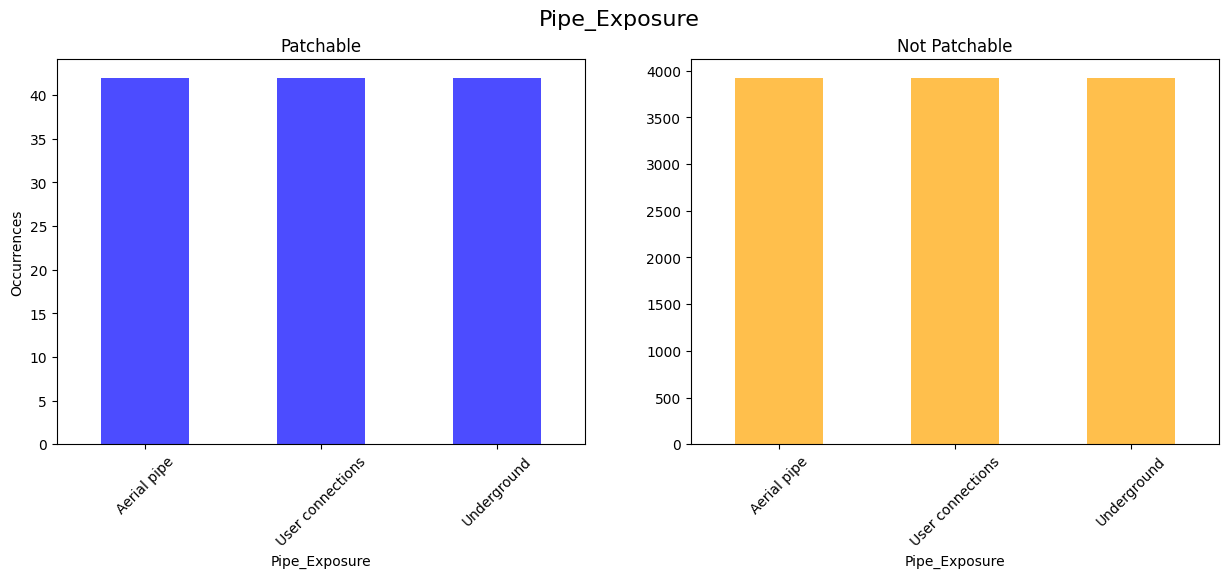

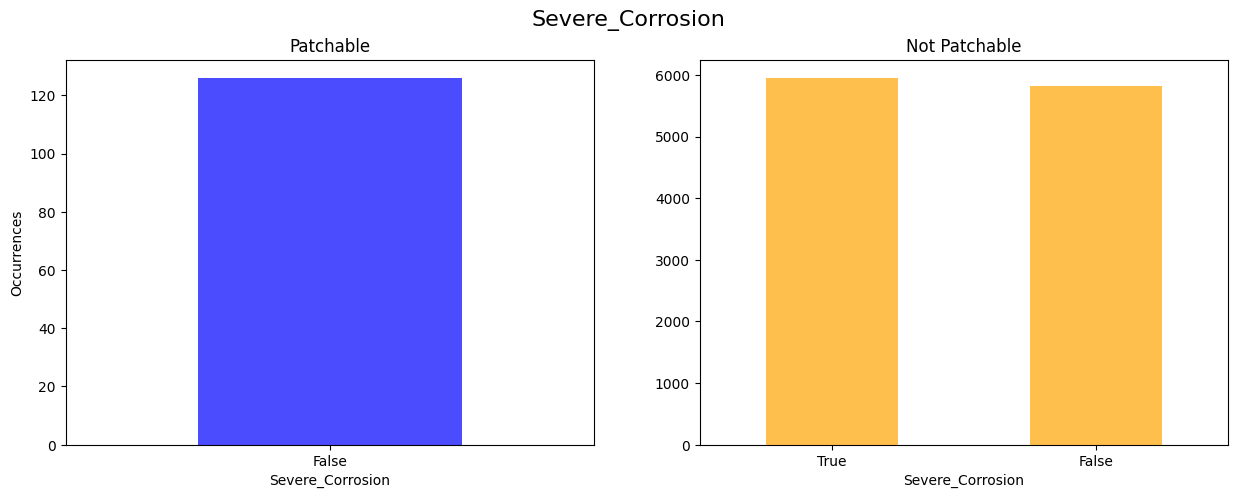

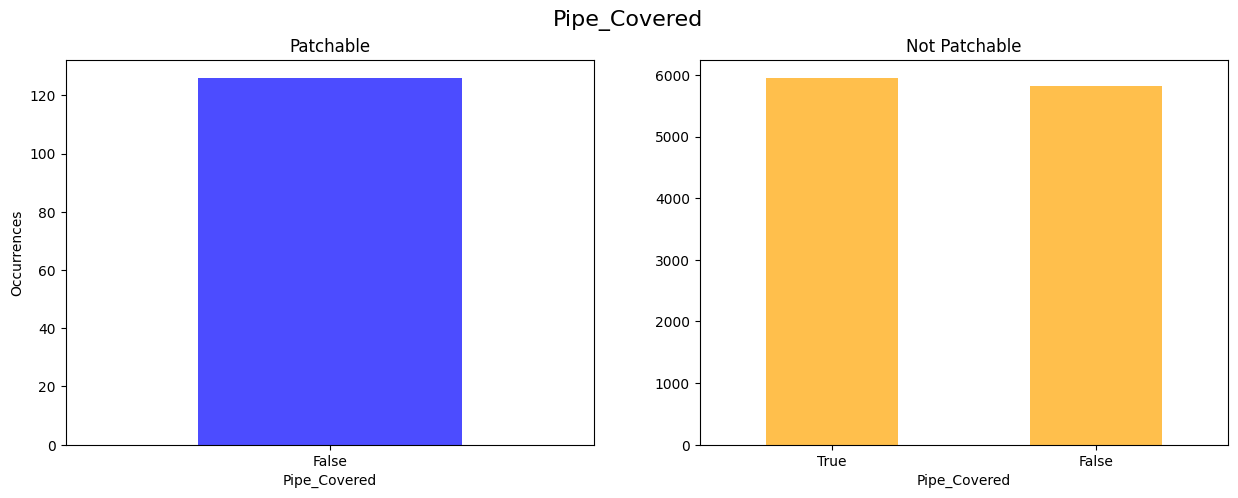

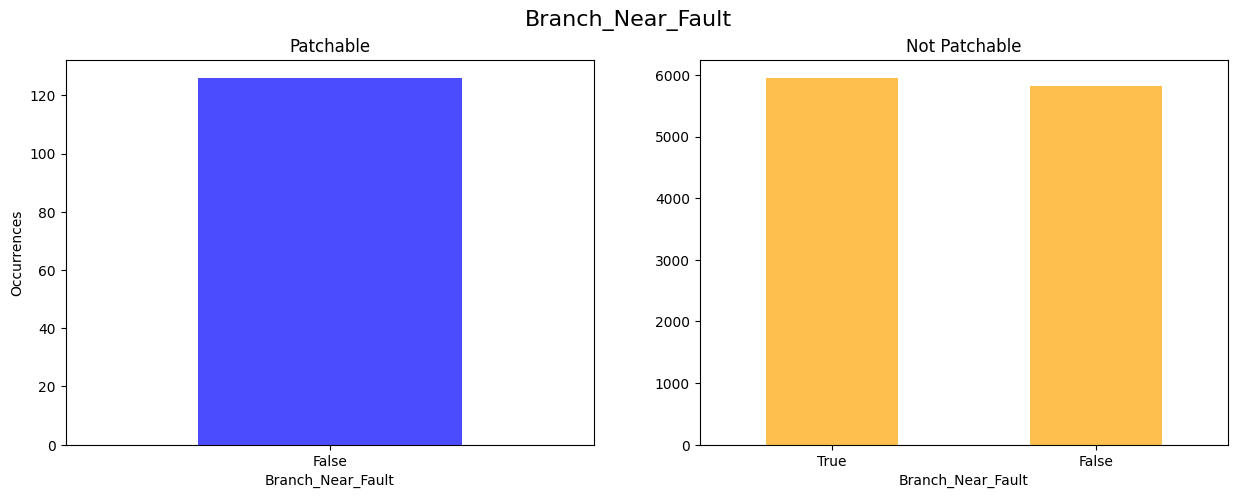

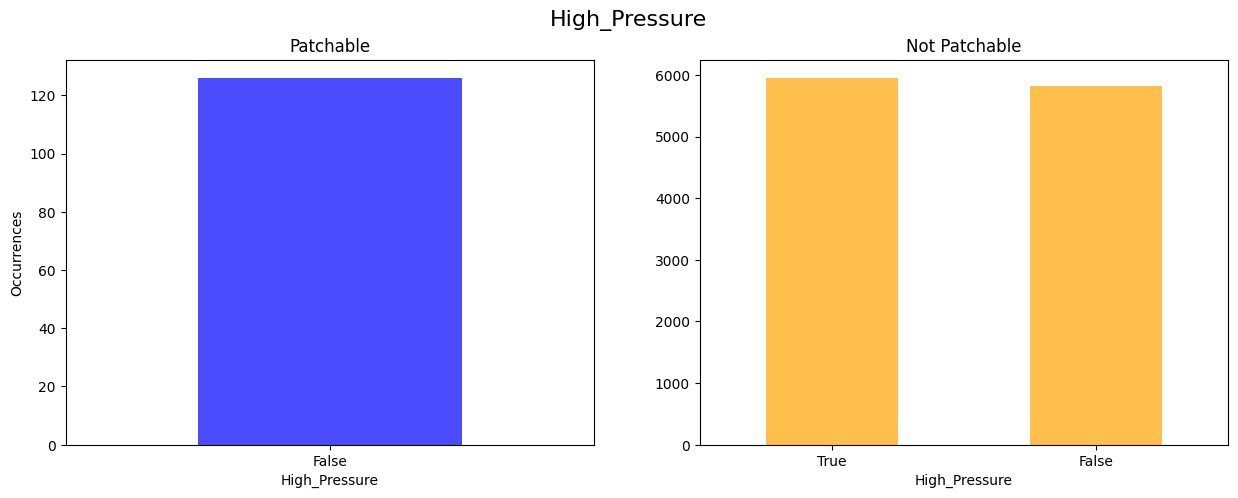

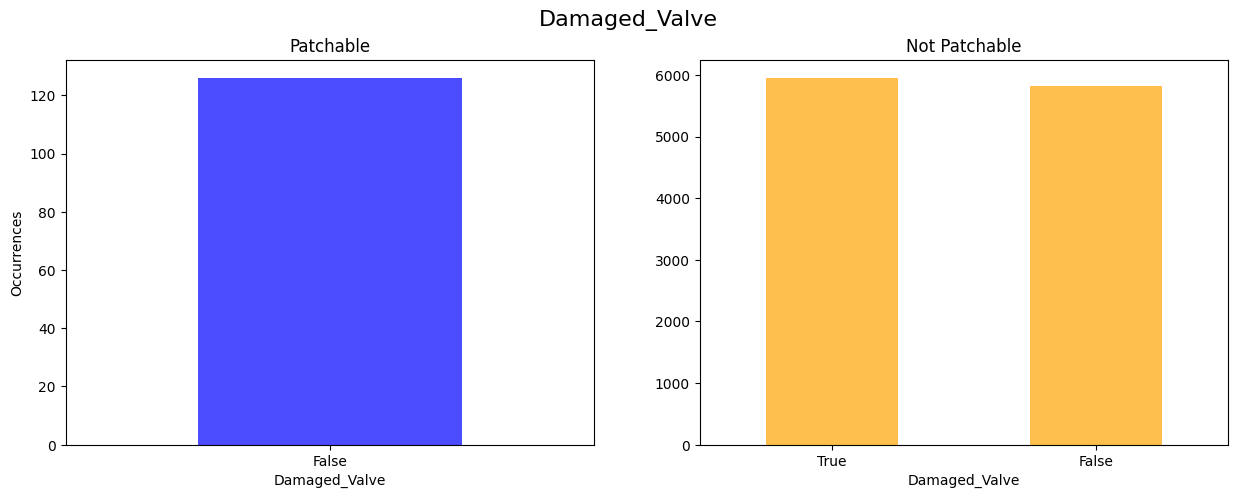

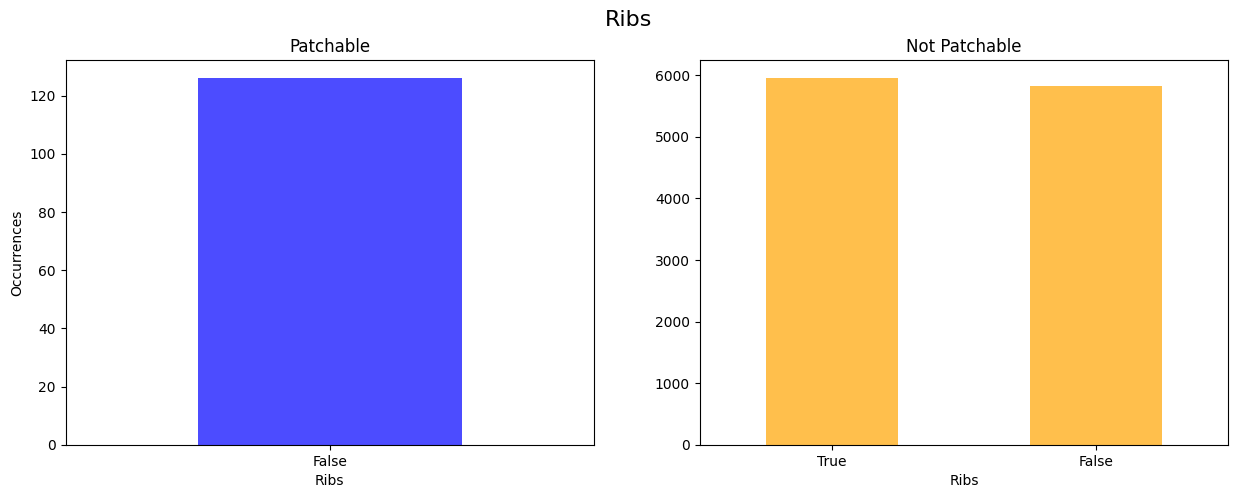

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
true_data = data[data['Successful']]
false_data = data[~data['Successful']]

# Excluded columns
excluded_columns = ['Summary', 'Summary_1', 'ID', 'Successful']

# Iterate through columns to plot
for column in data.columns:
    if column in excluded_columns:
        continue

    # Prepare data for plotting
    true_counts = true_data[column].value_counts()
    false_counts = false_data[column].value_counts()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(column, fontsize=16)

    # Plot true_data
    true_counts.plot(kind='bar', ax=axes[0], color='blue', alpha=0.7)
    axes[0].set_title("Patchable")
    axes[0].set_ylabel("Occurrences")
    axes[0].tick_params(axis='x', rotation=0 if all([isinstance(x,int) or isinstance(x,bool) for x in true_counts.index]) else 45)

    # Plot false_data
    false_counts.plot(kind='bar', ax=axes[1], color='orange', alpha=0.7)
    axes[1].set_title("Not Patchable")
    axes[1].tick_params(axis='x', rotation= 0 if all([isinstance(x,int) or isinstance(x,bool) for x in false_counts.index]) else 45)

    # Adjust layout and show the plot
    plt.show()


## Lexicon Variety
Our goal is to define a metric that capures how much the lexicon variates across documents d in a corpus D.

A document can be seen as a collection of terms:
$$ d = \{t_1,t_2, ... t_n\}$$

The vocabulary of a corpus is then made by all different terms that appear in D:
$$V_D = \{t_1,...,t_n\}$$

Let $p(t)$ be the probability of find $t$ in a document d:
$$ p(t) := \frac{|\{d \in D: t \in d\}|}{|D|} $$

The information content of t according to Shannon is:
$$I(t) = \log_2\left(\frac{1}{p(t)}\right)$$

Under the assumption that finding $x \in d$ does not influence the presence of $y \in d$:
$$I(\{x,y\}) = \log_2\left(\frac{1}{p(x,y)}\right) = \log_2\left(\frac{1}{p(x)}\frac{1}{p(y)}\right) = \log\left(\frac{1}{p(x)}\right) + \log\left(\frac{1}{p(y)}\right)$$

We define **lexicon variety** as the expected information content corpus' vocabulary:
$$L(V_D) := E[I(V_D)] =  \sum_{t \in V}p(t) \log_{2}\left(\frac{1}{p(t)}\right)$$

- if a term appears in _all_ documents, it's contribute is 0;
- if a term does not appear in the collection, it's contribute is also 0;
- the maximum value is proportional to the length of the vocabulary;
- the more a term belongs to a smaller subset of D, the more it contributes to I(V)



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Function to sample and preprocess a corpus
def preprocess_corpus(corpus, num_samples, seed=42):
    random.seed(seed)
    sampled_docs = random.sample(corpus, min(num_samples, len(corpus)))
    return [doc.strip() for doc in sampled_docs if isinstance(doc, str) and len(doc.split()) > 0]

common_crawl = load_dataset("cc_news", split="train")
stackexchange_law = load_dataset("ymoslem/Law-StackExchange", split = "train")
pubmed_qa = load_dataset("qiaojin/PubMedQA", "pqa_artificial",split = "train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
corpora_downsampled = {
    "cc_news": preprocess_corpus(common_crawl['text'],data.shape[0]),
    "stackexchange_law": preprocess_corpus(stackexchange_law["question_body"],data.shape[0]),
    "pubmed_qa": preprocess_corpus(pubmed_qa['question'],data.shape[0]),
    "gas_pipe_repairs" : data['Summary'].tolist()
}

corpora = {
    "cc_news": common_crawl['text'],
    "stackexchange_law": stackexchange_law["question_body"],
    "pubmed_qa": pubmed_qa['question'],
    "gas_pipe_repairs" : data['Summary'].tolist()
}

### Downsampled Corprora

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax

tfidfs_downsampled = {}
idfs_downsampled = {}
document_lengths_downsampled = {}

# TF-IDF, IDF
for corpus_name, corpus in corpora_downsampled.items():
    _tfidf = TfidfVectorizer(binary = True, use_idf=True, norm = None)
    tfidfs_downsampled[corpus_name] = _tfidf.fit_transform(corpus)
    idfs_downsampled[corpus_name] = _tfidf.idf_
    document_lengths_downsampled[corpus_name] = [len(doc.split()) for doc in corpus]


In [ ]:
tfidfs_downsampled['gas_pipe_repairs'].shape

(11904, 2556)

In [ ]:
ft= {corpus : np.array(tfidfs_downsampled[corpus].sum(axis = 0) / tfidfs_downsampled[corpus].shape[0]).flatten() for corpus in corpora_downsampled}

In [ ]:
corpora_summary_downsampled = {
    corpus: {
        "|D|": tfidfs_downsampled[corpus].shape[0],
        "|V|": tfidfs_downsampled[corpus].shape[1],
        "|V|/|D|": idfs_downsampled[corpus].shape[0] / tfidfs_downsampled[corpus].shape[0],
        "avg_text_length": np.mean(document_lengths_downsampled[corpus]),
        "L(V)": sum(ft[corpus]*np.log2(1/ft[corpus])),
    }
    for corpus in corpora_downsampled.keys()
}
lexical_entropy_summary_df_downsampled = pd.DataFrame(corpora_summary_downsampled).T
lexical_entropy_summary_df_downsampled[['|D|','|V|']] = lexical_entropy_summary_df_downsampled[['|D|','|V|']].astype(int)
lexical_entropy_summary_df_downsampled

,|D|,|V|,|V|/|D|,avg_text_length,L(V)
cc_news,11904,101993,8.567960,395.041163,3709.741304
stackexchange_law,11904,42447,3.565776,146.597950,1536.599807
pubmed_qa,11904,17873,1.501428,15.290995,473.119422
gas_pipe_repairs,11904,2556,0.214718,70.460517,215.350804


### Entire corpora

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax

tfidfs = {}
idfs = {}
document_lengths = {}

# TF-IDF, IDF
for corpus_name, corpus in corpora.items():
    _tfidf = TfidfVectorizer(use_idf=True)
    tfidfs[corpus_name] = _tfidf.fit_transform(corpus)
    idfs[corpus_name] = _tfidf.idf_
    document_lengths[corpus_name] = [len(doc.split()) for doc in corpus]

In [ ]:
ft= {corpus : np.array(tfidfs[corpus].sum(axis = 0) / tfidfs[corpus].shape[0]).flatten() for corpus in corpora}

In [ ]:
corpora_summary = {
    corpus: {
        "|D|": tfidfs[corpus].shape[0],
        "|V|": tfidfs[corpus].shape[1],
        "|V|/|D|": idfs[corpus].shape[0] / tfidfs[corpus].shape[0],
        "avg_text_length": np.mean(document_lengths[corpus]),
        "L(V)": sum(ft[corpus]*np.log2(1/ft[corpus])),
    }
    for corpus in corpora.keys()
}
lexical_entropy_summary_df = pd.DataFrame(corpora_summary).T
lexical_entropy_summary_df[['|D|','|V|']] = lexical_entropy_summary_df[['|D|','|V|']].astype(int)
lexical_entropy_summary_df

,|D|,|V|,|V|/|D|,avg_text_length,L(V)
cc_news,708241,884332,1.248631,396.812647,98.125584
stackexchange_law,24370,62895,2.580837,146.994173,66.754130
pubmed_qa,211269,71110,0.336585,15.344097,36.659225
gas_pipe_repairs,11904,2556,0.214718,70.460517,33.156464


## DB/Query Splitting

We split `DATA` 80/20 in DB (i.e. Retrieval System Memory, also refered as RAG Memory) and QUERY (i.e. test set, for evaluating performances) in a stratified fashion:
- The group DATA[False] is split 80% DB - 20% QUERY
- The ground DATA[True] is split 80% DB - 20% QUERY, namely: 101 $\in$ DB, 25 $\in$ QUERY.

In [ ]:
# Stratified splitting db/query (80-20)
from sklearn.model_selection import train_test_split
db,query = train_test_split(data, test_size=0.20, stratify=data['Successful'], random_state=42)

In [ ]:
# Store dbs
db.to_csv('DBs/db_full.csv')
query.to_csv('QUERIES/query_full.csv')

In [ ]:
# Downsampling Query
_query_positive = query[query['Successful']]
_query_negative = query[~query['Successful']].sample(n= _query_positive.shape[0] * 4,random_state = 42)
query_downsampled = pd.concat([_query_positive, _query_negative])
query_downsampled.to_csv('QUERIES/query_downsampled.csv')

In [ ]:
db_full = pd.read_csv("DBs/db_full.csv")
query_full = pd.read_csv("QUERIES/query_full.csv")

In [ ]:
query_full.shape

(2381, 16)

# Encoder Selection

Our HPs:
- foundation models does not necessarely perform as good as for general-purpose Information Retrieval (IR) tasks.
- foundation models maps low lexical entropy corpora in a very small surface of the d-hyperplan. Therefore, scaling on the unit d-hypersphere ends in collapsing furtherly the DB volume: the rotation might be not enough to capture nuances of summaries, lowering the ability of retrieve positive examples, expecialy in such (-) dense scenario.

### Hypotheses and Comparison of Pooling Methods

In corpora where the vocabulary remains constant across documents, we hypothesize that a document $\vec{d}$ of length $t$ can be expressed as:  
$$
\vec{d} = \alpha \vec{\text{CLS}} + \sum_{i=1}^{F}\beta_i \vec{e}_i + \sum_{j=1}^{t-F-1}\gamma_j \vec{r}_j,
$$   where:  
- $\vec{\text{CLS}}$: encodes the core semantic content (e.g., gas pipe repairs).  
- $\vec{e}_i$: Embeddings for $F$ structured features derived from the corpus, such as $\vec{e}_{\text{pressure}}$, $\vec{e}_{\text{corrosion}}$, or $\vec{e}_{\text{damage}}$.  
- $\vec{r}_j$: Residual embeddings for tokens outside the structured features. The residual component is labeled as such because we assume that the tokens in $\vec{r}$ shaped the $\vec{e}$ they were associated with, thanks to the attention mechanism.

In our documents, the primary meaningful contributions to $\vec{v}$ come from $\vec{\text{CLS}}$ and $\vec{e}_i$, while the residual component $\sum_{j=1}^{t-F-1}\gamma_j \vec{r}_j$ adds less significant information.

By expliciting cls and mean pooling sentence embedding:
1. **CLS Pooling**: $\vec{d}_{\text{CLS}} = \vec{\text{CLS}}$

2. **Mean Pooling**: $
\vec{d}_{\text{Mean}} = \frac{1}{t + 1} \vec{\text{CLS}} + \frac{1}{t + 1}\sum_{i=1}^{t} \vec{token}_i $

We can expect mean-pooling models outperform their cls based counterpart in our setting.


In [ ]:
candidates = [
    "multi-qa-mpnet-base-dot-v1", # TOP (SSS)
    "all-mpnet-base-v2", # TOP in Sentence Embedding, Top-2 in SSS Trained on large corpus (all-*)
    'bert-base-nli-mean-tokens',
    'bert-base-nli-cls-token'
]

In [ ]:
k_range = range(1,12,2)

In [ ]:
db_full = pd.read_csv('DBs/db_full.csv')
query_full = pd.read_csv('QUERIES/query_full.csv')

In [ ]:
# Define Retrieval Systems
retrieval_systems = {
    model_name : RetrievalSystem(db_full,model_name) for model_name in candidates
}

Instantiating embedding model: multi-qa-mpnet-base-dot-v1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: bert-base-nli-mean-tokens


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: bert-base-nli-cls-token


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.60k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


### Precision@k
Code has been removed: we rely on KNN

In [ ]:
# Overall
precision_viz['overall']

,1,3,5,7,9,11
multi-qa-mpnet-base-dot-v1,0.98320,0.98544,0.985720,0.985060,0.984927,0.984880
all-mpnet-base-v2,0.98404,0.98348,0.983452,0.983380,0.982920,0.982589
all-distilroberta-v1,0.98068,0.98348,0.983620,0.983080,0.983294,0.983200
stsb-roberta-large,0.98278,0.98082,0.981940,0.981820,0.981380,0.980909
bert-base-nli-mean-tokens,0.98026,0.97606,0.973961,0.974381,0.973914,0.973579


In [ ]:
# (+)
precision_viz['+']

,1,3,5,7,9,11
multi-qa-mpnet-base-dot-v1,0.00,0.013333,0.024,0.028571,0.022222,0.018182
all-mpnet-base-v2,0.04,0.040000,0.040,0.040000,0.035556,0.032727
all-distilroberta-v1,0.00,0.026667,0.032,0.022857,0.017778,0.014545
stsb-roberta-large,0.16,0.066667,0.056,0.068571,0.071111,0.069091
bert-base-nli-mean-tokens,0.36,0.253333,0.216,0.228571,0.217778,0.210909


In [ ]:
# (-)
precision_viz['-']

,1,3,5,7,9,11
multi-qa-mpnet-base-dot-v1,0.993633,0.995756,0.995925,0.995210,0.995142,0.995138
all-mpnet-base-v2,0.994058,0.993492,0.993463,0.993391,0.992973,0.992669
all-distilroberta-v1,0.991087,0.993633,0.993718,0.993269,0.993539,0.993479
stsb-roberta-large,0.991511,0.990521,0.991766,0.991511,0.991039,0.990585
bert-base-nli-mean-tokens,0.986842,0.983729,0.982003,0.982294,0.981937,0.981672


## KNN

In [ ]:
# Associate RAC to retrieval systems
racs = {
    c : RAC(retrieval_system = retrieval_systems[c]) for c in candidates
}

In [ ]:
# Collect performances of the models on KNN
def _test_policy(rac,query_df,**kwargs):
  _predictions = query_df["Summary"].apply(rac,**kwargs)
  return _compute_metrics(y_true = query_df['Successful'], y_pred = _predictions)

In [ ]:
knn_test = {
    candidate : {k: _test_policy(racs[candidate],query_full, policy = "knn", metric = "IP", top_k = k, upper_bound = None, lower_bound = None) for k in k_range} for candidate in candidates
}

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
for candidate in knn_test:
  knn_test[candidate] = pd.DataFrame(knn_test[candidate]).T
  knn_test[candidate].to_csv(f"RESULTS/knn_test_{candidate}.csv")

In [ ]:
avg_f1_knn_results = pd.DataFrame({candidate : knn_test[candidate]['Avg(F1)'] for candidate in candidates})
avg_f1_knn_results.to_csv('RESULTS/avg_f1_knn_results.csv')
avg_f1_knn_results

,multi-qa-mpnet-base-dot-v1,all-mpnet-base-v2,bert-base-nli-mean-tokens,bert-base-nli-cls-token
1,0.495765,0.520976,0.633458,0.600481
3,0.497361,0.497255,0.611138,0.615658
5,0.497361,0.497361,0.565847,0.525081
7,0.497361,0.497361,0.605039,0.528079
9,0.497361,0.497361,0.555651,0.534397
11,0.497361,0.497361,0.557540,0.534397


## Similarity Metrics

In [ ]:
best_rac = racs['bert-base-nli-mean-tokens']
metrics = ['IP','COS','L2-NOT-SCALED','L2-SCALED']

In [ ]:
# (-)es
_neg_df = query_full[~query_full['Successful']]
metric_selection_neg = pd.DataFrame({
    m: {f'Avg(F1)@{k}': _test_policy(best_rac, _neg_df, policy = "knn", top_k = k, metric=m)['Avg(F1)'] for k in k_range}
    for m in metrics
})

In [ ]:
# (+)es
_pos_df = query_full[query_full['Successful']]
metric_selection_pos = pd.DataFrame({
    m: {f'Avg(F1)@{k}': _test_policy(best_rac, _pos_df, policy = "knn", top_k = k, metric=m)['Avg(F1)'] for k in k_range}
    for m in metrics
})

In [ ]:
metric_selection_pos.to_csv('RESULTS/metric_selection_pos.csv')
metric_selection_neg.to_csv('RESULTS/metric_selection_neg.csv')

In [ ]:
metric_selection_pos

,IP,COS,L2-NOT-SCALED,L2-SCALED
Avg(F1)@1,0.264706,0.193548,0.193548,0.193548
Avg(F1)@3,0.193548,0.137931,0.137931,0.137931
Avg(F1)@5,0.107143,0.038462,0.038462,0.038462
Avg(F1)@7,0.137931,0.038462,0.000000,0.038462
Avg(F1)@9,0.074074,0.038462,0.000000,0.038462
Avg(F1)@11,0.074074,0.000000,0.000000,0.000000


In [ ]:
metric_selection_neg

,IP,COS,L2-NOT-SCALED,L2-SCALED
Avg(F1)@1,0.496689,0.498403,0.498510,0.498403
Avg(F1)@3,0.497762,0.499363,0.499256,0.499363
Avg(F1)@5,0.498403,0.499469,0.499469,0.499469
Avg(F1)@7,0.499150,0.499788,0.499788,0.499788
Avg(F1)@9,0.499256,0.499894,0.499894,0.499894
Avg(F1)@11,0.499363,0.500000,0.500000,0.500000


In [ ]:
import numpy as np

# Combine all embeddings into a single matrix
all_embeddings = np.vstack(best_rac.embeddings['not_scaled'])

# Compute variance for each dimension
variances = np.var(all_embeddings, axis=0)

# Find the index of the dimension with the maximal variance
max_variance_index = np.argmax(variances)
min_variance_index = np.argmin(variances)

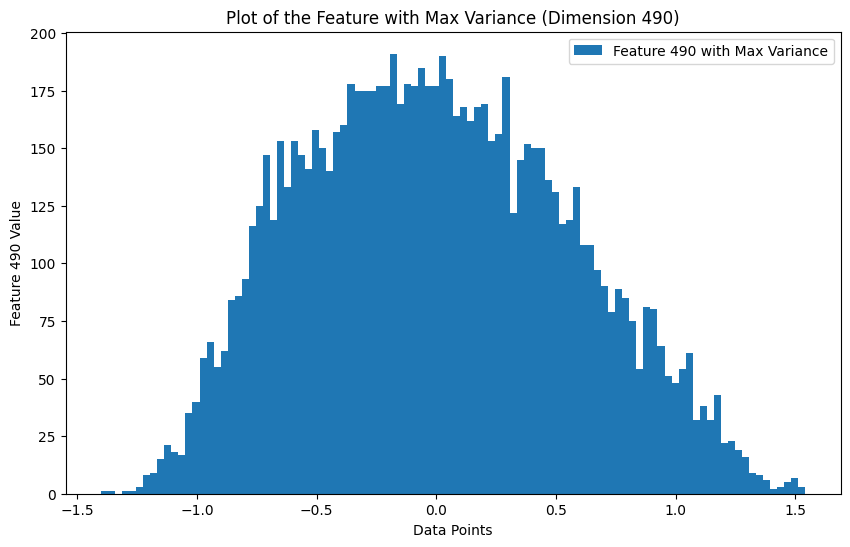

Feature 490 has the maximal variance: 0.3060910999774933


In [ ]:

# Plot the feature with the maximal variance
plt.figure(figsize=(10, 6))
plt.hist(all_embeddings[:, max_variance_index], label=f"Feature {max_variance_index} with Max Variance", bins=100)
plt.title(f"Plot of the Feature with Max Variance (Dimension {max_variance_index})")
plt.xlabel("Data Points")
plt.ylabel(f"Feature {max_variance_index} Value")
plt.legend()
plt.show()

print(f"Feature {max_variance_index} has the maximal variance: {variances[max_variance_index]}")

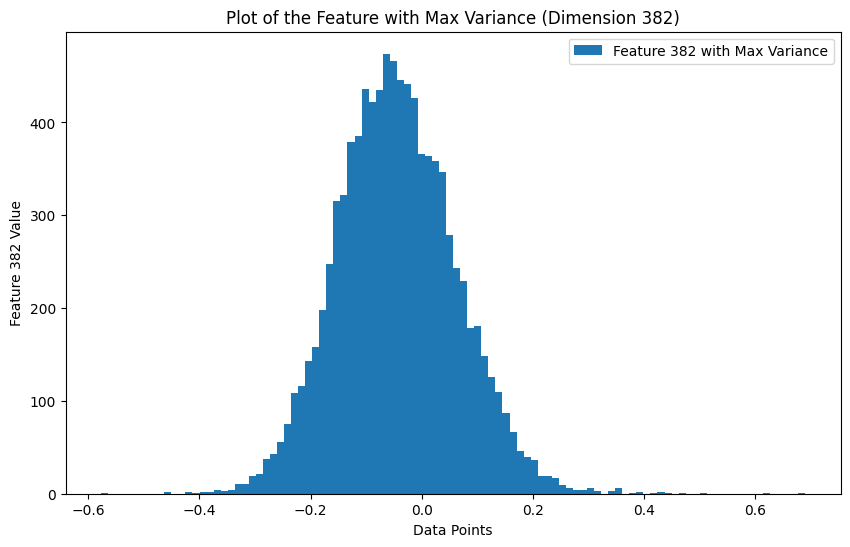

Feature 382 has the maximal variance: 0.01147075742483139


In [ ]:
# Plot the feature with the maximal variance
plt.figure(figsize=(10, 6))
plt.hist(all_embeddings[:, min_variance_index], label=f"Feature {min_variance_index} with Max Variance", bins=100)
plt.title(f"Plot of the Feature with Max Variance (Dimension {min_variance_index})")
plt.xlabel("Data Points")
plt.ylabel(f"Feature {min_variance_index} Value")
plt.legend()
plt.show()

print(f"Feature {min_variance_index} has the maximal variance: {variances[min_variance_index]}")

## CLS vs MEAN





In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Load models and tokenizers
bert_mean = {
    'tokenizer': AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens'),
    'model': AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
}

bert_cls = {
    'tokenizer': AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-cls-token'),
    'model': AutoModel.from_pretrained('sentence-transformers/bert-base-nli-cls-token')
}
bert_mean['model'].to('cuda:0')
bert_cls['model'].to('cuda:0')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Function to compute embeddings on CUDA in batches
def compute_embeddings_in_batches(texts, tokenizer, model, pooling_type, device, batch_size=32):
    norms = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**encoded)
        token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        cls_embedding = outputs.pooler_output  # [batch_size, hidden_dim]
        if pooling_type == "cls":
            norms.extend(torch.norm(cls_embedding, dim=1).cpu().tolist())
        elif pooling_type == "mean":
            norms.extend(torch.norm(token_embeddings.mean(dim=1), dim=1).cpu().tolist())
        elif pooling_type == "mean-no-cls":
            token_embeddings_without_cls = token_embeddings[:, 1:, :]  # Exclude CLS token
            norms.extend(torch.norm(token_embeddings_without_cls.mean(dim=1), dim=1).cpu().tolist())
    return norms

# Compute norms on CUDA with batching
device = torch.device('cuda:0')
batch_size = 16  # Adjust based on GPU memory capacity
norms = {
    "cls": {
        "bert_mean": compute_embeddings_in_batches(db_full["Summary"].to_list(), bert_mean["tokenizer"], bert_mean["model"], "cls", device, batch_size),
        "bert_cls": compute_embeddings_in_batches(db_full["Summary"].to_list(), bert_cls["tokenizer"], bert_cls["model"], "cls", device, batch_size),
    },
    "mean": {
        "bert_mean": compute_embeddings_in_batches(db_full["Summary"].to_list(), bert_mean["tokenizer"], bert_mean["model"], "mean", device, batch_size),
        "bert_cls": compute_embeddings_in_batches(db_full["Summary"].to_list(), bert_cls["tokenizer"], bert_cls["model"], "mean", device, batch_size),
    },
    "mean_no_cls": {
        "bert_mean": compute_embeddings_in_batches(db_full["Summary"].to_list(), bert_mean["tokenizer"], bert_mean["model"], "mean-no-cls", device, batch_size),
        "bert_cls": compute_embeddings_in_batches(db_full["Summary"].to_list(), bert_cls["tokenizer"], bert_cls["model"], "mean-no-cls", device, batch_size),
    },
}


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


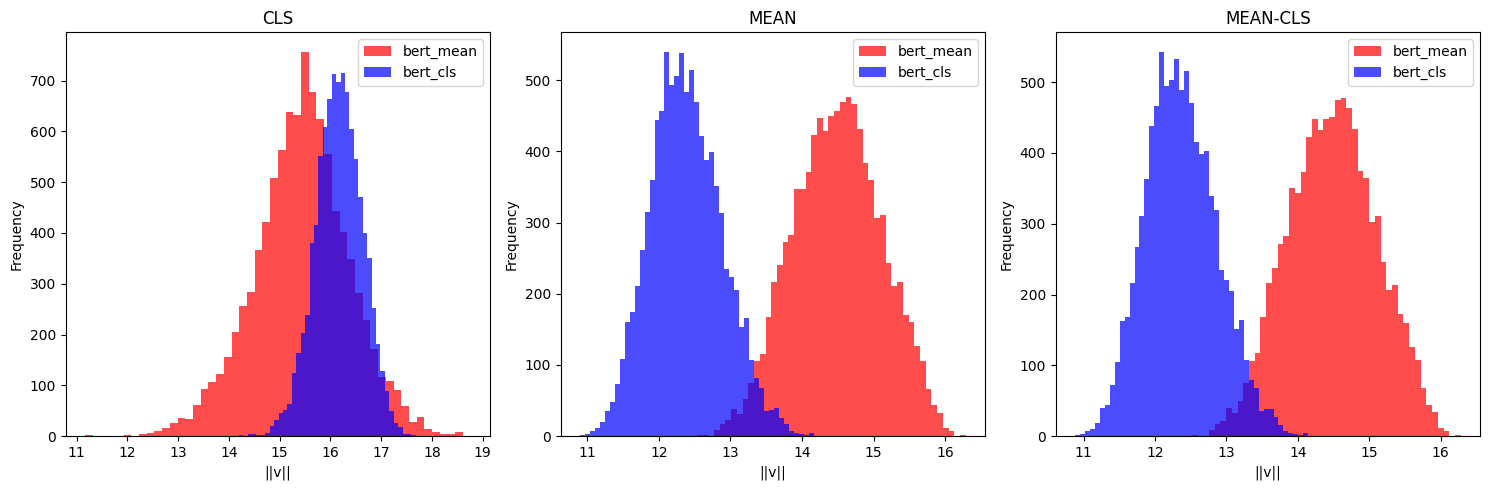

In [ ]:
# Plot distributions
titles = ["CLS", "MEAN", "MEAN vector without CLS"]
colors = {"bert_mean": "red", "bert_cls": "blue"}
plt.figure(figsize=(15, 5))

for i, key in enumerate(norms.keys()):
    plt.subplot(1, 3, i + 1)
    for model_key in norms[key]:
        plt.hist(norms[key][model_key], bins=50, alpha=0.7, color=colors[model_key], label=model_key)
    plt.title(titles[i])
    plt.xlabel("||v||")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()


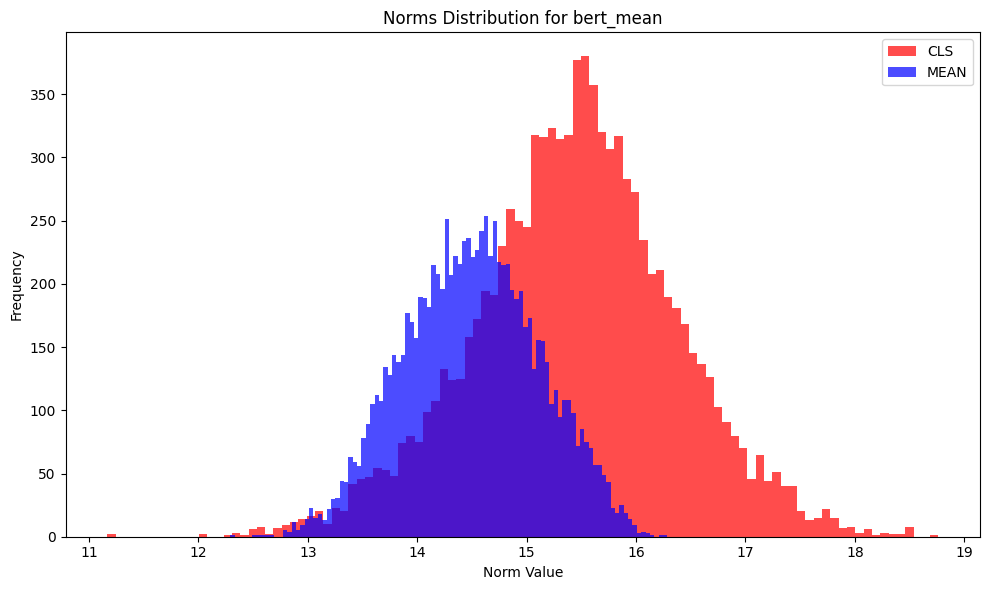

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'norms' dictionary contains pre-computed norms

# Select the model you want to plot (e.g., 'bert_mean' or 'bert_cls')
model_name = "bert_mean"  # Change to 'bert_cls' to plot for the other model

# Plot both CLS and MEAN norms on the same graph
plt.figure(figsize=(10, 6))

# Plot CLS norm distribution
plt.hist(norms["cls"][model_name], bins=100, alpha=0.7, color='red', label='CLS')

# Plot MEAN norm distribution
plt.hist(norms["mean"][model_name], bins=100, alpha=0.7, color='blue', label='MEAN')

plt.title(f'Norms Distribution for {model_name}')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Download the list of stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Set of punctuation marks
punctuation_set = set(string.punctuation)

# Load tokenizer and model
bert_mean = {
    'tokenizer': AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens'),
    'model': AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
}

# Initialize tokenizer and model
tokenizer = bert_mean['tokenizer']

# Function to process text in batches
def get_most_frequent_tokens(texts, batch_size=32):
    token_counter = Counter()
    token_without_stopwords_counter = Counter()

    # Process the texts in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        # Tokenize the current batch of texts
        batch_texts = texts[i:i + batch_size]
        # Tokenize the texts (this converts them to token ids)
        encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors='pt')

        # Extract tokens for each text in the batch
        for encoding in encodings['input_ids']:
            tokens = encoding.tolist()
            # Remove padding tokens (token id 0) and update counter
            tokens = [token for token in tokens if token != tokenizer.pad_token_id]
            token_counter.update(tokens)

            # Now, remove stopwords and punctuation, and update the counter for tokens without stopwords
            decoded_tokens = [tokenizer.decode([token_id]).strip() for token_id in tokens]
            filtered_tokens = [token for token in decoded_tokens if token.lower() not in stop_words and token not in punctuation_set]
            token_without_stopwords_counter.update(filtered_tokens)

    # Get the 30 most frequent tokens (without stopwords and punctuation)
    most_common_tokens_without_stopwords = token_without_stopwords_counter.most_common(30)
    most_common_tokens_without_stopwords_with_words = [(token, count) for token, count in most_common_tokens_without_stopwords]

    # Return dictionary with the most frequent tokens excluding stopwords and punctuation
    return dict(most_common_tokens_without_stopwords_with_words)

texts = data['Summary'].tolist()  # Convert to list if it's a Pandas DataFrame


# Get the dictionary with the most frequent tokens excluding stopwords and punctuation
result = get_most_frequent_tokens(texts)


In [ ]:
# Output the results
print(result)

{'pipe': 34564, 'break': 16550, 'near': 16287, 'corrosion': 14361, 'pressure': 13197, 'strong': 12730, 'high': 12460, '[CLS]': 11904, '[SEP]': 11904, 'ribs': 11257, 'wall': 10626, 'covered': 9710, 'conditions': 9483, 'presence': 9296, 'branch': 8662, 'valve': 8448, 'bad': 8442, 'due': 7716, 'fault': 7454, 'steel': 6072, 'present': 5777, 'within': 4790, 'injury': 4500, 'aerial': 4258, 'shear': 4246, '##ion': 4226, 'les': 4212, 'may': 4194, '##ed': 4107, 'linear': 4084}


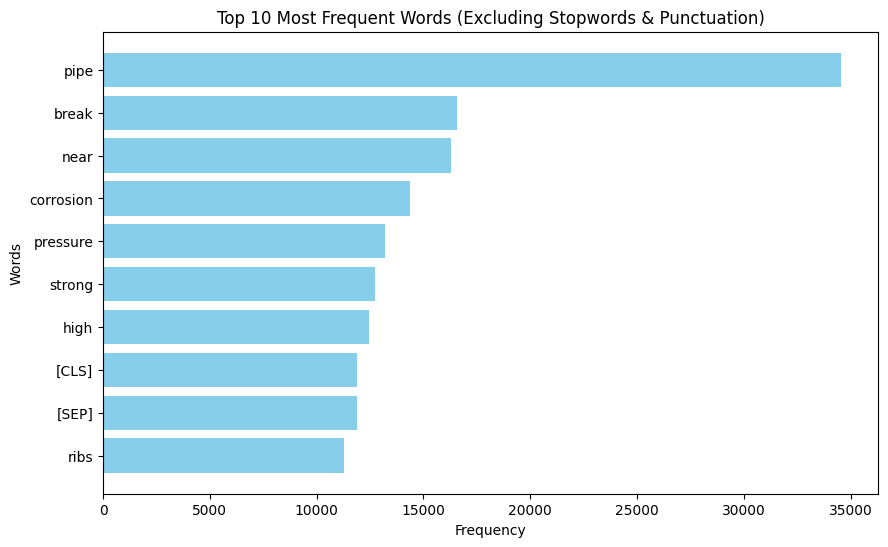

In [ ]:
# Set the number of top-k words to display
k = 10  # You can adjust this value to display the top-k words

# Get the top-k most frequent words (excluding stopwords and punctuation)
top_k_words = dict(list(result.items())[:k])

# Plotting the bar chart for the top-k words
plt.figure(figsize=(10, 6))
plt.barh(list(top_k_words.keys()), list(top_k_words.values()), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title(f'Top {k} Most Frequent Words (Excluding Stopwords & Punctuation)')
plt.gca().invert_yaxis()  # To show the most frequent word on top
plt.show()

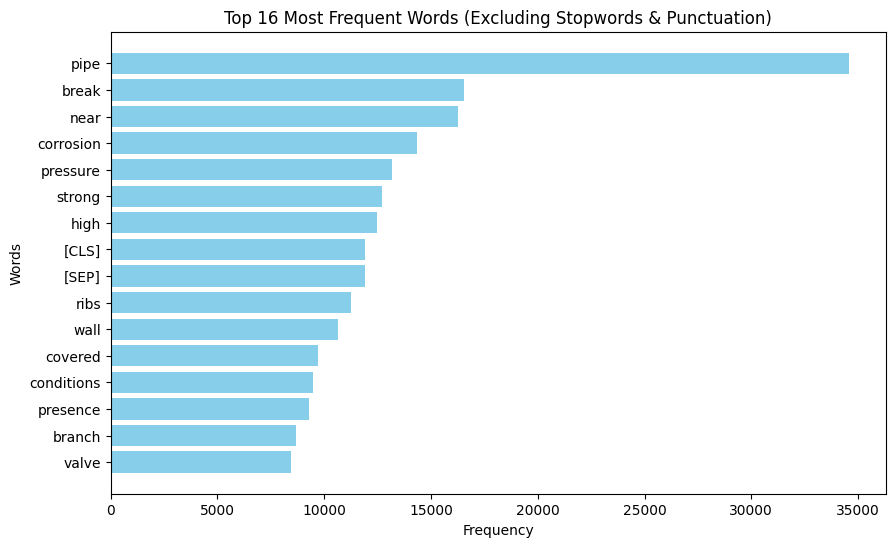

In [ ]:
# Set the number of top-k words to display
k = 16  # You can adjust this value to display the top-k words

# Get the top-k most frequent words (excluding stopwords and punctuation)
top_k_words = dict(list(result.items())[:k])

# Plotting the bar chart for the top-k words
plt.figure(figsize=(10, 6))
plt.barh(list(top_k_words.keys()), list(top_k_words.values()), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title(f'Top {k} Most Frequent Words (Excluding Stopwords & Punctuation)')
plt.gca().invert_yaxis()  # To show the most frequent word on top
plt.show()

# Decoder Selection
We select the most promising model for gas pipe repairs classification by asking him to label queries without seeing any example (intrinsic knowledge)

In [ ]:
models_names = ['llama3.2','llama2:13b','mistral']

In [ ]:
template= """
You are a pipeline maintenance assistant with expertise in gas pipe repairs.
Your task is to determine if a pipe leak can be repaired by patches.

Answer selecting one of the following options:
- "YES" if the damage can be repaired by patches;
- "NO" if the damage cannot be repaired by patches.
** do not write any word but either YES or NO**

### Damage Description:
{description}

Answer:"""

In [ ]:
# Helper function to simplify generation
from warnings import warn
def generate(description,chain):
  resp = chain.invoke({'description':description})
  return resp

# Helper function to normalize the answer
def normalize(resp):
  _r = resp.strip().strip("\n").strip('.').upper()
  if _r == "YES":
    return True
  if _r == "NO":
    return False
  else:
    warn(f"The answer {resp} does not match neither YES nor NO.")
    return resp

In [ ]:
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import ChatPromptTemplate

# Create prompt for chatting
prompt = ChatPromptTemplate.from_template(template)

# Create a chain for each mode
chains = {model_name : prompt | OllamaLLM(model=model_name) for model_name in models_names}

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

def run_zero_shot(model_name, queries, chains, generate, normalize, downsample=None, n_runs=5):
    metrics = {}

    # Generate answers using the model for the first run
    raw_answers = queries['Summary'].apply(generate, chain=chains[model_name])
    answers = raw_answers.apply(normalize)

    # Detect non-compliant answers
    _to_evaluate = [id for id, a in answers.items() if isinstance(a, bool)]
    y_true = queries['Successful'].loc[_to_evaluate].astype(bool)
    y_pred = answers.loc[_to_evaluate].astype(bool)

    # Calculate main metrics
    p, r, f, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average=None)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Print metrics
    print("--------------------------------------------------------")
    print(f"Metrics for model {model_name}:")
    print(f"Avg(F1): {sum(f) / 2:.3f}")
    print(f"Avg(P): {sum(p) / 2:.3f}")
    print(f"Avg(R): {sum(r) / 2:.3f}")
    print(f"P(+): {p[1]:.3f}, R(+): {r[1]:.3f}, F1(+): {f[1]:.3f}")
    print(f"P(-): {p[0]:.3f}, R(-): {r[0]:.3f}, F1(-): {f[0]:.3f}")
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print("--------------------------------------------------------")

    # Calculate Self Consistency
    # Downsample the data for self-consistency
    query_for_self_consistency= queries

    # Run the model n_runs times on the same subset and collect predictions
    all_answers = []

    for _ in range(n_runs):
        raw_answers_run = query_for_self_consistency['Summary'].apply(generate, chain=chains[model_name])
        answers_run = raw_answers_run.apply(normalize)
        all_answers.append(answers_run)

    # Convert list of predictions into a DataFrame
    all_answers_df = pd.DataFrame(all_answers).T

    # Check for consistency across the n runs
    stable_predictions = (all_answers_df.nunique(axis=1) == 1).sum()
    consistency = stable_predictions / len(all_answers_df)

    print(f"Self Consistency: {consistency:.3f}")

    # Record metrics in dictionary
    metrics = {
        'Avg(F1)': sum(f) / 2,
        'Self Consistency': consistency,  # This is the normalized self-consistency value
    }

    # Save results to CSV
    results_df = pd.DataFrame([metrics])
    results_df.to_csv(f"RESULTS/{model_name}_zero_shot.csv", index=False)

    return metrics

### Downsampled

In [ ]:
# Downsampled query run
query_downsampled = pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")
zero_shot_results_downsampled = { model_name : run_zero_shot(model_name, query_downsampled, chains, generate, normalize) for model_name in models_names}

--------------------------------------------------------
Metrics for model llama3.2:
Avg(F1): 0.620
Avg(P): 0.627
Avg(R): 0.615
P(+): 0.409, R(+): 0.360, F1(+): 0.383
P(-): 0.845, R(-): 0.870, F1(-): 0.857
TP: 9, FP: 13, TN: 87, FN: 16
--------------------------------------------------------
Self Consistency: 0.752


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------------------------
Metrics for model llama2:13b:
Avg(F1): 0.444
Avg(P): 0.400
Avg(R): 0.500
P(+): 0.000, R(+): 0.000, F1(+): 0.000
P(-): 0.800, R(-): 1.000, F1(-): 0.889
TP: 0, FP: 0, TN: 100, FN: 25
--------------------------------------------------------
Self Consistency: 1.000
--------------------------------------------------------
Metrics for model mistral:
Avg(F1): 0.676
Avg(P): 0.683
Avg(R): 0.780
P(+): 0.407, R(+): 0.880, F1(+): 0.557
P(-): 0.958, R(-): 0.680, F1(-): 0.795
TP: 22, FP: 32, TN: 68, FN: 3
--------------------------------------------------------


<ipython-input-75-82f2d4227f25>:15: UserWarning: The answer  YES (assuming that the repair technique allows for patching under the described circumstances) does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")


Self Consistency: 0.864


<ipython-input-75-82f2d4227f25>:15: UserWarning: The answer  YES (Assuming that patching methods suitable for cast iron pipes are available, and the hole is repairable without significant risk to the overall system. However, it's essential to thoroughly inspect the pipe and surrounding area before making any repairs.) does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")


In [ ]:
# Show table with Avg(F1)
avg_f1_zero_shot_downsampled = pd.DataFrame({model_name : zero_shot_results_downsampled[model_name]['Avg(F1)'] for model_name in models_names}, index=['Avg(F1)'])
avg_f1_zero_shot_downsampled.to_csv(f"RESULTS/avg_f1_zero_shot_downsampled.csv")
avg_f1_zero_shot_downsampled

,llama3.2,llama2:13b,mistral
Avg(F1),0.620061,0.444444,0.676142


In [ ]:
# Show table for self consistency
self_consistency_zero_shot_downsampled = pd.DataFrame({model_name : zero_shot_results_downsampled[model_name]['Self Consistency'] for model_name in models_names}, index=['Self Consistency'])
self_consistency_zero_shot_downsampled.to_csv(f"RESULTS/self_consistency_zero_shot_downsampled.csv")
self_consistency_zero_shot_downsampled

,llama3.2,llama2:13b,mistral
Self Consistency,0.752,1.0,0.864


In [ ]:
pd.DataFrame(zero_shot_results_downsampled).to_csv("RESULTS/zero_shot_results_downsampled.csv")
pd.DataFrame(zero_shot_results_downsampled).T

,Avg(F1),Self Consistency
llama3.2,0.620061,0.752
llama2:13b,0.444444,1.000
mistral,0.676142,0.864


# Retrieval Augmented Generation.
We test Mistral7B by providing examples retrieved through `bert-base-nli-mean-tokens`.

We test two different prompts:
- Non-informed: while being provided with examples reteieved by similarity, the model is not informed about the background process
- RAG-aware.

In [ ]:
rag_template = """
You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "{description}"

Here some examples:
{examples}

Task:
1. Analyze the similarities and differences between the query and the retrieved cases.
2. Based on your analysis, answer by selecting **one and only one** among the following two labels:
  - "YES" if the damage can be repaired by patches;
  - "NO" if the damage cannot be repaired by patches.

YOUR ANSWER MUST INCLUDE **ONLY AND ONLY** THE LABEL: do not write your analysis or any other word besides the label YES or the label NO.
### Label:
"""

In [ ]:
rag_informed_template = """
You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "{description}"

We also retrieved the {k} most similar cases from the database. Below are their descriptions and outcomes:
{examples}

Among the {k} neighbors:
- {true_count} are labeled as "YES" (patchable).
- {false_count} are labeled as "NO" (not patchable).

Task:
1. Analyze the similarities and differences between the query and the retrieved cases.
2. Based on your analysis, answer by selecting **one and only one** among the following two labels:
  - "YES" if the damage can be repaired by patches;
  - "NO" if the damage cannot be repaired by patches.

YOUR ANSWER MUST INCLUDE **ONLY AND ONLY** THE LABEL: do not write your analysis or any other word besides the label YES or the label NO.
### Label:
"""

In [21]:
example_template = """{i}.) {description} --> Label: {label}"""

In [ ]:
# Load db and query
db_full = pd.read_csv("DBs/db_full.csv")
query_full = pd.read_csv("QUERIES/query_full.csv")
query_downsampled= pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")

In [ ]:
def test_rag(
    rag: RAG,
    queries,
    top_k: int,
    prompt_template: str,
    example_template: str,
    **kwargs,
):
    """
    Test the RAG system on a set of queries.

    Args:
        rag (RAG): The RAG object.
        queries (pd.DataFrame): DataFrame containing the queries and true labels.
        top_k (int): Number of top results to retrieve.
        prompt_template (str): Template for the prompt.
        example_template (str): Template for the examples.

    Returns:
        List[bool]: List of RAG's predictions for the queries.
    """
    predictions = []
    for _, row in queries.iterrows():
        query = row['Summary']
        pred = rag(
            query=query,
            prompt_template=prompt_template,
            example_template=example_template,
            top_k=top_k,
            **kwargs
        )
        predictions.append(pred)
    return predictions

In [ ]:
k_range = range(1,12,2)

In [ ]:
best_encoder_name = 'bert-base-nli-mean-tokens'
best_decoder_name = 'mistral'

In [ ]:
# In case of runtime disconnection, instantiate the encoder
best_encoder = RetrievalSystem(db_full,best_encoder_name)

Instantiating embedding model: bert-base-nli-mean-tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
results = []
rag = RAG(best_encoder,best_decoder_name)
# Test RAG under both templates
for k in k_range:
    for template in [rag_template, rag_informed_template]:
        predictions = test_rag(
            rag=rag,
            queries=query_downsampled,
            top_k=k,
            prompt_template=template,
            example_template=example_template,
            split = False
        )
        avg_f1 = compute_avgf1(query_downsampled['Successful'], predictions)
        results.append({
            'template': 'rag' if template == rag_template else 'rag_informed',
            'top_k': k,
            'avg_f1': avg_f1
        })

# Create DataFrame and save results
rag_results = pd.DataFrame(results)
rag_results.to_csv("RESULTS/rag_db_full.csv", index=False)

print("Results saved to RESULTS/rag_db_full.csv")

<ipython-input-12-2cebe050e190>:24: UserWarning: The answer  Label: YES does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")
<ipython-input-12-2cebe050e190>:24: UserWarning: The answer  Label: YES does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")


Results saved to RESULTS/rag_db_full.csv


In [ ]:
# Creazione del dataframe
df = pd.DataFrame(results)

# Pivot per ottenere template come colonne, top_k come indici e avg_f1 come entry
df_pivoted = df.pivot(index='top_k', columns='template', values='avg_f1')

df_pivoted

template,rag,rag_informed
top_k,,
1,0.751738,0.717608
3,0.730364,0.693627
5,0.751378,0.703254
7,0.740395,0.668342
9,0.729986,0.740395
11,0.717608,0.684385


## Downsampling DB
Idea: since we observe that as k increases as the performance downgrades, we argue that the negative points shadows the positive ones.

We can model our RAG system as an augmented-knn where the model domain-knowledge can favor a class over the other, even if the pure count favors the other.

However, as k increase, as more the negative examples retrieved are in the neighborhood, due to their higher density (99 negatives for each positive).

Therefore, we decide to wipe out examples to stick on positives, cleaning up positive neighborhood, to enhance their retrieval.

In [ ]:
# 1:1 equal proportion
_db_positive = db_full[db_full['Successful']]
_db_negative = db_full[~db_full['Successful']].sample(n= _db_positive.shape[0],random_state = 42)
db_downsampled_1_1 = pd.concat([_db_positive, _db_negative])

In [ ]:
avg_distance = {}
for k in range(1,12,1):
  intra_cluster_distances = []
  # Retrieve top-k according to L2
  for q in _db_positive['Summary']:
    # Compute avg (+) distance from its cluste
    neighborhood = best_encoder(q,top_k=k,upper_bound=None,lower_bound=None,metric='L2-NOT-SCALED',split=True)
    intra_cluster_distances.append(neighborhood[~neighborhood['Successful']]['L2-NOT-SCALED'].to_list())
  intra_cluster_distances_unfold = [ d for cluster in intra_cluster_distances for d in cluster ]
  avg_distance[k] = sum(intra_cluster_distances_unfold) / len(intra_cluster_distances_unfold)

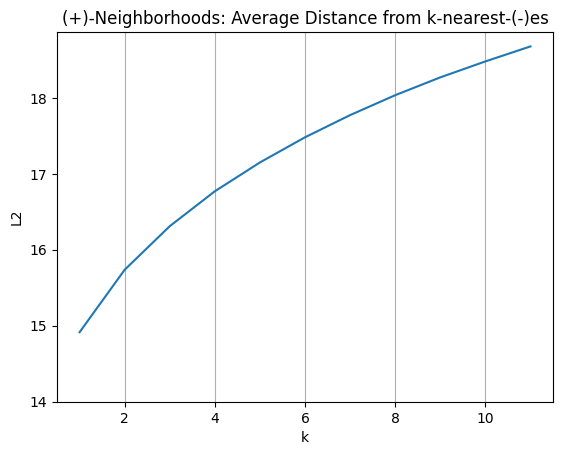

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x=list(avg_distance.keys())
y=list(avg_distance.values())
ax.plot(x,y)
ax.set_xlabel('k')
ax.set_ylabel('L2')
plt.title("(+)-Neighborhoods: Average Distance from k-nearest-(-)es")
ax.set_yticks(np.arange(int(y[0]),int(y[-1]) + 1))
ax.grid(axis='x')

In [ ]:
avg_distance

{1: 14.915165377135324,
 2: 15.736841350498766,
 3: 16.31065639489555,
 4: 16.770180106163025,
 5: 17.14955709948398,
 6: 17.48089149289399,
 7: 17.772715594846087,
 8: 18.034837153288397,
 9: 18.26957987217751,
 10: 18.479501288480098,
 11: 18.676931871797027}

In [ ]:
elbow_point = 15.74

In [ ]:
# Collecting points to be dropped from db
to_drop = []
for q in _db_positive['Summary']:
  # Retrieve neighborhood to r
  neighborhood = best_encoder(q,top_k=db_full.shape[0],upper_bound=elbow_point,lower_bound=None,metric='L2-NOT-SCALED',split=True)
  # Consider only negative points
  neighborhood_neg = neighborhood[~neighborhood['Successful']]
  # Collect their ids
  to_drop.extend(neighborhood_neg['ID'])
# Showing them
to_drop= set(to_drop)
print(f"#Removed objects= {len(to_drop)}")
print(to_drop)

#Removed objects= 507
{'ID009344', 'ID004282', 'ID000720', 'ID009247', 'ID002356', 'ID003007', 'ID001214', 'ID011833', 'ID001150', 'ID002360', 'ID010941', 'ID001886', 'ID006190', 'ID004863', 'ID010687', 'ID004028', 'ID005311', 'ID005720', 'ID011452', 'ID004975', 'ID003560', 'ID008764', 'ID002206', 'ID008383', 'ID007840', 'ID002732', 'ID006847', 'ID003512', 'ID002208', 'ID001087', 'ID005359', 'ID011831', 'ID000702', 'ID006815', 'ID008831', 'ID007486', 'ID007286', 'ID008511', 'ID006450', 'ID005684', 'ID007710', 'ID011072', 'ID004648', 'ID000567', 'ID007080', 'ID001582', 'ID011456', 'ID004271', 'ID006526', 'ID011327', 'ID003680', 'ID003504', 'ID003902', 'ID011904', 'ID003600', 'ID011520', 'ID003854', 'ID000048', 'ID003071', 'ID000544', 'ID011600', 'ID007024', 'ID010654', 'ID005872', 'ID002620', 'ID010392', 'ID000438', 'ID009215', 'ID011595', 'ID009088', 'ID006830', 'ID009279', 'ID008054', 'ID011064', 'ID007279', 'ID004540', 'ID007007', 'ID000312', 'ID001151', 'ID003254', 'ID011128', 'ID00

In [ ]:
db_expl = db_full[~db_full['ID'].isin(to_drop)].copy()

In [ ]:
db_expl.to_csv("DBs/db_expl.csv",index = False)

In [ ]:
db_downsampled_1_1.to_csv("DBs/db_1:1.csv")

In [ ]:
# Precision@K def
def precision_at_k(query_df : pd.DataFrame, retrieval_system : RetrievalSystem, k : int, metric : str = 'IP'):
  n_relevant = 0
  for _, q in query_df.iterrows():
    # Retrieve
    neighborhood = retrieval_system.retrieve(
        query = q[retrieval_system._summary_name],
        top_k = k,
        split = False,
        upper_bound = None,
        lower_bound = None,
        metric = metric,
    )

    # Get Neighborhood labels
    labels = neighborhood['Successful'].values
    relevant_value = q['Successful']

    # Count Relevant Items
    n_relevant += sum(relevant_value == l for l in labels)

  return n_relevant / (k*query_df.shape[0])

In [ ]:
db_full = pd.read_csv("DBs/db_full.csv")
db_11 = pd.read_csv("DBs/db_1:1.csv")
db_expl = pd.read_csv("DBs/db_expl.csv")
query_full = pd.read_csv("QUERIES/query_full.csv")

In [ ]:
best_encoder_name = 'bert-base-nli-mean-tokens'

In [ ]:
candidates = {
    name : RetrievalSystem(db,best_encoder_name) for name,db in [('db_full',db_full),('db_1:1',db_11),("db_expl",db_expl)]
}

Instantiating embedding model: bert-base-nli-mean-tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
candidates['db_full'].db.shape

(9523, 16)

In [ ]:
candidates['db_1:1'].db.shape

(202, 17)

In [ ]:
candidates['db_expl'].db.shape

(9016, 16)

In [ ]:
precisions = {
    db_name : [] for db_name in candidates
}

# Iterate over k values and retrieval systems to compute precisions
for k in k_range:
    for _db_name,_rs in candidates.items():
        # Compute precision for "overall"
        precision_overall = precision_at_k(query_full, _rs, k=k)
        precisions[_db_name].append(precision_overall)

# Create DataFrame for overall precisions
precision_viz_overall = pd.DataFrame(precisions, index=k_range)
precision_viz_overall.to_csv('RESULTS/precision_viz_overall.csv')

In [ ]:
precision_viz_overall

,db_full,db_1:1,db_expl
1,0.996535,0.766565,0.967132
3,0.982919,0.724632,0.955686
5,0.979775,0.702342,0.951780
7,0.977978,0.687118,0.950781
9,0.977038,0.677669,0.951241
11,0.976564,0.668764,0.951219


In [ ]:
k_range = range(1,12,2)

In [ ]:
query_full[query_full['Successful']].shape

(25, 16)

In [ ]:
precisions_pos = {
    db_name : [] for db_name in candidates
}
for k in k_range:
    for _db_name,_rs in candidates.items():
        precision_pos = precision_at_k(query_full[query_full['Successful']], _rs, k=k)
        precisions_pos[_db_name].append(precision_pos)

In [ ]:
precision_viz_pos = pd.DataFrame(precisions_pos, index = k_range)
precision_viz_pos.to_csv("RESULTS/precision_pos.csv")

In [ ]:
precision_viz_pos

,db_full,db_1:1,db_expl
1,0.360000,0.800000,0.560000
3,0.253333,0.813333,0.546667
5,0.216000,0.808000,0.536000
7,0.228571,0.800000,0.531429
9,0.217778,0.813333,0.506667
11,0.210909,0.825455,0.490909


## Downsampled vs Full-DB

In [ ]:
best_decoder_name = 'mistral'

In [ ]:
k = 5 # best performances for full_db

In [ ]:
query_downsampled = pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")

In [ ]:
results = {db_name : [] for db_name in candidates if db_name != 'db_full'}
# For each system
for db_name in results:
    # For both templates
    _results = {}
    for template_name,template in [('rag', rag_template), ('rag_informed', rag_informed_template)]:
      # Compute predictions
        predictions = test_rag(
            rag=RAG(candidates[db_name],best_decoder_name),
            queries=query_downsampled,
            top_k=k,
            prompt_template=template,
            example_template=example_template,
            split = False
        )

        # Score
        avg_f1 = compute_avgf1(query_downsampled['Successful'], predictions)

        # Save
        _results[template_name] = avg_f1
    results[db_name] = _results

# Create DataFrame and save results
rag_results_downsampled = pd.DataFrame(results)
rag_results_downsampled.to_csv("RESULTS/rag_@5_db_downsampled.csv", index=False)

In [ ]:
rag_results_downsampled

,db_1:1,db_expl
rag,0.785518,0.817436
rag_informed,0.773551,0.813512


In [ ]:
# Test the best model for all ks as we did for full_db
best_encoder_name = "db_expl"
results_expl = []
rag = RAG(candidates[best_encoder_name],best_decoder_name)
# Test RAG under both templates
for k in k_range:
    for template in [rag_template, rag_informed_template]:
        predictions = test_rag(
            rag=rag,
            queries=query_downsampled,
            top_k=k,
            prompt_template=template,
            example_template=example_template,
            split = False
        )
        avg_f1 = compute_avgf1(query_downsampled['Successful'], predictions)
        results_expl.append({
            'template': 'rag' if template == rag_template else 'rag_informed',
            'top_k': k,
            'avg_f1': avg_f1
        })

# Create DataFrame and save results_expl
rag_results_expl = pd.DataFrame(results_expl)

# Pivot per ottenere template come colonne, top_k come indici e avg_f1 come entry
rag_results_expl = rag_results_expl.pivot(index='top_k', columns='template', values='avg_f1')

rag_results_expl.to_csv("RESULTS/rag_db_expl.csv", index=False)
rag_results_expl

template,rag,rag_informed
top_k,,
1,0.839538,0.779347
3,0.793729,0.829682
5,0.806929,0.813512
7,0.796748,0.813512
9,0.871081,0.806929
11,0.850949,0.829682


# Few Shot
We use the same template as rag but fixing with constant examples.

In [ ]:
# Randomly sampling a couple of
examples_random_df = pd.concat([
    db_full[db_full['Successful']].sample(n=2),
    db_full[~db_full['Successful']].sample(n=2)
])[['Successful', 'Summary']]
examples_random_df[['Successful','Summary']]

,Successful,Summary
977,True,A hole has developed in this cast iron undergr...
5532,True,A galvanized nipple fault has occurred in an a...
3455,False,Aerial galvanized pipe nipple damage occurred ...
487,False,A sheared linear lesion has occurred in the bi...


In [ ]:
# Create examples text
examples = "\n".join(
    [ example_template.format(
        description = x['Summary'],
        label = "YES" if x['Successful'] else "NO",
        i = index + 1
    ) for index, (_,x) in enumerate(examples_random_df.iterrows())]
)

In [ ]:
prompt = ChatPromptTemplate.from_template(rag_template)
chain = prompt | OllamaLLM(model=best_decoder_name)
def generate(x : pd.Series):
  return chain.invoke({
      'description': x['Summary'],
      'examples' : examples,
  })

def classify(x : pd.Series):
  return RAG._normalize(generate(x))

In [ ]:
# Predict
predictions = query_downsampled.apply(classify,axis = 1)

# Score
avg_f1 = compute_avgf1(query_downsampled['Successful'].to_list(),predictions.to_list())

print(avg_f1)

0.8135123614663257


In [ ]:
# Positive few shot
# Randomly sampling a couple of
examples_random_df = pd.concat([
    db_full[db_full['Successful']].sample(n=4),
])[['Successful', 'Summary']]

examples = "\n".join(
    [ example_template.format(
        description = x['Summary'],
        label = "YES" if x['Successful'] else "NO",
        i = index + 1
    ) for index, (_,x) in enumerate(examples_random_df.iterrows())]
)

# Predict
predictions_pos = query_downsampled.apply(classify,axis = 1)

# Score
avg_f1_pos = compute_avgf1(query_downsampled['Successful'].to_list(),predictions_pos.to_list())

print(avg_f1_pos)

0.6386009449263099


# Free-Text Generation
In a rel-world scenario, it's more likely a gasfitter looking for an anwser and description.
In this section:
- We show how a prompt looks like before being feed into Mistral
- We show a free-text model answer, by simply removing the constraint from the prompt.

In [7]:
rag_template_free_text = """
You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "{description}"

Here some examples:
{examples}

Task:
1. Analyze the similarities and differences between the query and the retrieved cases.
2. Based on your analysis, answer by selecting **one and only one** among the following two labels:
  - "YES" if the damage can be repaired by patches;
  - "NO" if the damage cannot be repaired by patches.

### Answer:
"""

In [14]:
query_full = pd.read_csv("QUERIES/query_full.csv")

In [17]:
db_expl = pd.read_csv("DBs/db_expl.csv")

In [23]:
q = query_full.iloc[0]['Summary']
print(q)

A visible deformation in the axial direction, caused by strong corrosion in Bitomato steel, has occurred underground and at high pressure within the pipe. The presence of valves nearby and ribs on the pipe wall suggest that this injury is not due to external factors such as branch damage or poor coating but rather due to internal corrosive forces. Even though the pipe is not covered by a wall, its location beneath the surface makes it more susceptible to corrosion, leading to the visible deformation observed.


In [20]:
rs = RetrievalSystem(db_expl,'bert-base-nli-mean-tokens')

Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [30]:
rag = RAG(rs,'mistral')

In [28]:
answer = rag.generate(q,rag_template_free_text,example_template,top_k = 9,split = False)
print(answer)

1. The query describes a visible deformation in the axial direction of an underground Bitomato steel pipe due to strong corrosion and high pressure. The presence of valves nearby and ribs on the pipe wall suggest that this injury is not due to external factors such as branch damage or poor coating but rather due to internal corrosive forces. Unlike the examples provided, this description mentions the specific type of steel (Bitomato) and its susceptibility to corrosion due to its location beneath the surface.

2. Based on the analysis, it appears that the damage described in the query is not patchable (NO). The presence of strong corrosion and high pressure within the pipe, as well as the fact that the pipe is not covered by a wall, indicate that this injury may be more severe than just a localized fault. This suggests that the damage might require more extensive repairs beyond simple patching, such as replacing damaged sections of the pipe or reinforcing it to prevent future deformati

In [31]:
answer = rag.generate(query_full.iloc[-1]['Summary'],rag_template_free_text,example_template,top_k = 9,split = False, print_prompt = True)
print(answer)


You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "A polyethylene-coated steel aerial pipe has suffered a hole injury under bad conditions. Although strong corrosion is present, high pressure within the pipe is not an issue. There is no branch near the break and the pipe is not covered by a wall. Fortunately, a valve is located near the break, but there are no ribs present to provide additional support. The injury is characterized by a hole."

Here some examples:
1.) A polyethylene-coated steel pipe has suffered a hole injury at its user connections due to bad conditions. The injury is not caused by strong corrosion, and there is no high pressure in the pipe. The break occurred near a branch connection, and the pipe is covered by a wall. Additionally, a valve is located near the break. There are no ribs present on the

In [33]:
query_full.iloc[-1]['Successful']

False